<a href="https://colab.research.google.com/github/ZeHou21/ma0218/blob/main/MA0218_miniproj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fraud Detection (Classification)**

In this scenario, we do not have a direct "fraud" label in the dataset. However, we can use the "Attrition Flag" as a proxy for detecting irregular behavior. While "Attrition Flag" is typically used to indicate customer churn, we can adapt it for fraud detection. Specifically, we can assume that customers with "Attrition Flag" = 1 might represent customers with suspicious or anomalous behavior, such as fraudulent activities. These customers could show sudden spikes in their spending, transaction frequency, or credit utilization.

**Dataset:** Credit Card

**Contents**
1. Import Required Libraries
2. Importing Data
3. Data Preparations
4. Data Visualization and Analysis
5. Choosing the Best Model
6. Finding Individual Predictor That Best Predict Fraud
7. Comparing Income_Category vs Attrition_Flag on Actual Test Data
8. Conclusion

**1. Import Required Libraries**

In [ ]:
# --- Basic Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Visualization ---
import seaborn as sb
import seaborn as sns # Keeping both aliases for seaborn
sb.set()  # Set the default Seaborn style for graphics using 'sb' alias
sns.set() # Set the default Seaborn style for graphics using 'sns' alias

# --- Preprocessing ---
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample
from collections import Counter

# --- Model Selection ---
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)

# --- Models ---
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR

# --- Evaluation Metrics ---
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    mean_squared_error,
    r2_score
)

# --- Imbalanced Data Handling ---
from imblearn.over_sampling import SMOTE

# --- Distributions for Hyperparameter Tuning ---
from scipy.stats import randint

**2. Importing Data**

In [ ]:
# Load file into dataframe
financedata = pd.read_csv('/Finance.csv')
# Print first 5 rows
financedata.head()

,CLIENTNUM,Attrition_Flag,Year,Quarter,Date,Type,Trans_Amount,Revenue
0,708082083,Existing Customer,2018,Q1,"Q1,2018",Shop,120.120,2.4024
1,708083283,Attrited Customer,2018,Q1,"Q1,2018",Shop,135.555,2.7111
2,708084558,Attrited Customer,2018,Q1,"Q1,2018",Shop,396.270,7.9254
3,708085458,Existing Customer,2018,Q1,"Q1,2018",Shop,122.955,2.4591
4,708086958,Existing Customer,2018,Q1,"Q1,2018",Shop,134.640,2.6928


In [ ]:
# Load file into dataframe
revenuetarget_data = pd.read_csv('/revenue_target.csv')
# Print first 5 rows
revenuetarget_data.head()

,CLIENTNUM,quarter,Year,Date,Type,Card_Category,Target Revenue
0,708082083,Q1,2018,"Q1,2018",Shop,Blue,4.204200
1,708083283,Q1,2018,"Q1,2018",Shop,Blue,4.744425
2,708084558,Q1,2018,"Q1,2018",Shop,Blue,13.869450
3,708085458,Q1,2018,"Q1,2018",Shop,Blue,4.303425
4,708086958,Q1,2018,"Q1,2018",Shop,Blue,4.712400


In [ ]:
# Load file into dataframe
info_data = pd.read_csv('/infoall.csv')
# Print first 5 rows
info_data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Trans_Ct,Avg_Utilization_Ratio,Quarter,Year,Date_Leave
0,712672083,Existing Customer,65,F,0,High School,Married,Less than $40K,Blue,36,...,3,2,1438.3,747,691.3,24,0.519,none,2018,"none,2018"
1,713049933,Existing Customer,47,F,1,Graduate,Married,$40K - $60K,Silver,36,...,2,2,5756.0,0,5756.0,44,0.000,none,2018,"none,2018"
2,713049933,Existing Customer,48,F,1,Graduate,Married,$40K - $60K,Silver,48,...,6,2,5756.0,990,5756.0,25,0.170,none,2019,"none,2019"
3,713135883,Existing Customer,65,F,0,College,Married,Less than $40K,Blue,65,...,5,0,4315.0,393,3598.0,73,0.090,none,2019,"none,2019"
4,713135883,Existing Customer,64,F,0,College,Married,Less than $40K,Blue,53,...,3,0,4315.0,717,3598.0,51,0.166,none,2018,"none,2018"


**3. Data Preparations**

**3.1. Data Merging**

Data from Finance, Revenue and Info is merged into a single file for easy usage

In [ ]:
# Standardize column names for merging
financedata = financedata.rename(columns={"Date": "date", "Type": "type", "CLIENTNUM": "clientnum"})
revenuetarget_data = revenuetarget_data.rename(columns={"Date": "date", "Type": "type", "CLIENTNUM": "clientnum"})
info_data = info_data.rename(columns={"CLIENTNUM": "clientnum"})

# Merge finance and revenue_target on clientnum, date, type
merged_fin_rev = pd.merge(financedata, revenuetarget_data, on=["clientnum", "date", "type"], how="inner")

# Merge with infoall on clientnum
merged_data = pd.merge(merged_fin_rev, info_data, on="clientnum", how="left")

#Print first 5 rows of merged data
merged_data.head()

,clientnum,Attrition_Flag_x,Year_x,Quarter_x,date,type,Trans_Amount,Revenue,quarter,Year_y,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Trans_Ct,Avg_Utilization_Ratio,Quarter_y,Year,Date_Leave
0,708082083,Existing Customer,2018,Q1,"Q1,2018",Shop,120.120,2.4024,Q1,2018,...,2,3,3544.0,943,1883.0,44,0.270,none,2019,"none,2019"
1,708082083,Existing Customer,2018,Q1,"Q1,2018",Shop,120.120,2.4024,Q1,2018,...,3,3,3544.0,1661,1883.0,111,0.469,none,2018,"none,2018"
2,708083283,Attrited Customer,2018,Q1,"Q1,2018",Shop,135.555,2.7111,Q1,2018,...,1,3,3421.0,2517,904.0,21,0.736,Q4,2018,"Q4,2018"
3,708084558,Attrited Customer,2018,Q1,"Q1,2018",Shop,396.270,7.9254,Q1,2018,...,3,3,8258.0,1771,6487.0,23,0.214,Q2,2018,"Q2,2018"
4,708085458,Existing Customer,2018,Q1,"Q1,2018",Shop,122.955,2.4591,Q1,2018,...,2,2,1500.0,784,1438.3,47,0.520,Q4,2019,"Q4,2019"


In [ ]:
features = ['Trans_Amount', 'Revenue', 'Target Revenue', 'Customer_Age', 'Gender', 'Marital_Status', 'Income_Category', 'Card_Category_y']

# Create the final cleaned dataset (select only the necessary columns)
New_data=merged_data[features].copy()

New_data.head()

,Trans_Amount,Revenue,Target Revenue,Customer_Age,Gender,Marital_Status,Income_Category,Card_Category_y
0,120.120,2.4024,4.204200,46,F,Married,$40K - $60K,Blue
1,120.120,2.4024,4.204200,45,F,Married,$40K - $60K,Blue
2,135.555,2.7111,4.744425,58,M,Single,$40K - $60K,Blue
3,396.270,7.9254,13.869450,60,M,Divorced,$60K - $80K,Silver
4,122.955,2.4591,4.303425,35,F,Single,Less than $40K,Blue


In [ ]:
#Check number of missing values for each variable
New_data.isnull().sum()

,0
Trans_Amount,0
Revenue,0
Target Revenue,0
Customer_Age,0
Gender,0
Marital_Status,0
Income_Category,0
Card_Category_y,0


## Labeling Categorical into integers
## **Customer_Age**
- The `Customer_Age` column can be divided into age groups:
  - `0-16` → `0`
  - `17-32` → `1`
  - `33-48` → `2`
  - `49-64` → `3`
  - `More than 64` → `4`

## **Marital_Status**:
The `Marital_Status` column is mapped as:
- `Single` → `0`
- `Married` → `1`
- `Divorced` → `2`

## **Gender**:
- `M` → `1`
- `F` → `0`

## **Income_Category**
- The `Income_Category` column contains values such as:
  - `Less than $40K` → `0`
  - `$40K - $60K` → `1`
  - `$60K - $80K` → `2`
  - `$80K - $120K` → `3`
  - `Greater than $120K` → `4`

## **Card_Category_y**:
The card categories are mapped as follows:
- `Blue` → `0`
- `Silver` → `1`
- `Gold` → `2`
- `Platinum` → `3`


In [ ]:
# Create a copy of New_data to avoid overwriting it
Transformed_data = New_data.copy()

# Customer_Age
Transformed_data.loc[Transformed_data['Customer_Age'] <= 16, 'Customer_Age'] = 0
Transformed_data.loc[(Transformed_data['Customer_Age'] > 16) & (Transformed_data['Customer_Age'] <= 32), 'Customer_Age'] = 1
Transformed_data.loc[(Transformed_data['Customer_Age'] > 32) & (Transformed_data['Customer_Age'] <= 48), 'Customer_Age'] = 2
Transformed_data.loc[(Transformed_data['Customer_Age'] > 48) & (Transformed_data['Customer_Age'] <= 64), 'Customer_Age'] = 3
Transformed_data.loc[Transformed_data['Customer_Age'] > 64, 'Customer_Age'] = 4

# Gender
Transformed_data['Gender'] = Transformed_data['Gender'].map({'M': 1, 'F': 0}).astype('int8')

# Marital_Status
marital_status_map = {'Single': 0, 'Married': 1, 'Divorced': 2}
Transformed_data['Marital_Status'] = Transformed_data['Marital_Status'].map(marital_status_map).astype('int8')

# Income_Category
income_map = {
    'Less than $40K': 0,
    '$40K - $60K': 1,
    '$60K - $80K': 2,
    '$80K - $120K': 3,
    '$120K +': 4
}
Transformed_data['Income_Category'] = Transformed_data['Income_Category'].map(income_map).astype('int8')

# Card_Category_y
card_category_map = {'Blue': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3}
Transformed_data['Card_Category_y'] = Transformed_data['Card_Category_y'].map(card_category_map).astype('int8')

# Check the output
Transformed_data.head()

,Trans_Amount,Revenue,Target Revenue,Customer_Age,Gender,Marital_Status,Income_Category,Card_Category_y
0,120.120,2.4024,4.204200,2,0,1,1,0
1,120.120,2.4024,4.204200,2,0,1,1,0
2,135.555,2.7111,4.744425,3,1,0,1,0
3,396.270,7.9254,13.869450,3,1,2,2,1
4,122.955,2.4591,4.303425,2,0,0,0,0


In [ ]:
# Change data types for categorical columns to integers
Transformed_data['Gender'] = Transformed_data['Gender'].astype('int32')  # Gender as int32
Transformed_data['Marital_Status'] = Transformed_data['Marital_Status'].astype('int32')  # Marital Status as int32
Transformed_data['Income_Category'] = Transformed_data['Income_Category'].astype('int32')  # Income Category as int32
Transformed_data['Card_Category_y'] = Transformed_data['Card_Category_y'].astype('int32')  # Card Category as int32

Transformed_data.dtypes

,0
Trans_Amount,float64
Revenue,float64
Target Revenue,float64
Customer_Age,int64
Gender,int32
Marital_Status,int32
Income_Category,int32
Card_Category_y,int32


## Define Fraudulent Behavior Using IQR (High Outliers Only)

To detect potentially fraudulent transactions, we analyze each customer's `Trans_Amount` based on their `Income_Category`.

We define a transaction as **fraudulent** (`Attrition_Flag = 1`) if the transaction amount is unusually high for their income group. This is determined using the Interquartile Range (IQR) method:

1. For each income category (0 to 4), calculate the 25th percentile (Q1) and 75th percentile (Q3) of `Trans_Amount`.
2. Compute the IQR as:  
   **IQR = Q3 - Q1**
3. Define the upper threshold as:  
   **Upper Bound = Q3 + 1.5 × IQR**
4. Flag transactions as:
   - `1` (Fraudulent) if `Trans_Amount > Upper Bound`
   - `0` (Non-Fraudulent) otherwise


In [ ]:
def detect_high_outliers_by_IQR(df):
    df = df.copy()  # Avoid modifying original df
    df['Attrition_Flag'] = 0  # Reset flags

    grouped = df.groupby('Income_Category')['Trans_Amount']
    Q3 = grouped.quantile(0.75)
    IQR = grouped.quantile(0.75) - grouped.quantile(0.25)
    upper_bound = Q3 + 1.5 * IQR

    for income_cat in df['Income_Category'].unique():
        ub = upper_bound[income_cat]
        df.loc[(df['Income_Category'] == income_cat) &
               (df['Trans_Amount'] > ub), 'Attrition_Flag'] = 1

    return df

# Apply and verify
Transformed_data = detect_high_outliers_by_IQR(Transformed_data)

# Count flags
fraudulent_count = Transformed_data['Attrition_Flag'].sum()
non_fraudulent_count = len(Transformed_data) - fraudulent_count

print(f"Number of fraudulent transactions (Attrition_Flag = 1): {fraudulent_count}")
print(f"Number of non-fraudulent transactions (Attrition_Flag = 0): {non_fraudulent_count}")
print(f"Total transactions: {len(Transformed_data)}")
print(f"Fraudulent percentage: {fraudulent_count / len(Transformed_data) * 100:.2f}%")

Transformed_data.head()

Number of fraudulent transactions (Attrition_Flag = 1): 50451
Number of non-fraudulent transactions (Attrition_Flag = 0): 522553
Total transactions: 573004
Fraudulent percentage: 8.80%


,Trans_Amount,Revenue,Target Revenue,Customer_Age,Gender,Marital_Status,Income_Category,Card_Category_y,Attrition_Flag
0,120.120,2.4024,4.204200,2,0,1,1,0,0
1,120.120,2.4024,4.204200,2,0,1,1,0,0
2,135.555,2.7111,4.744425,3,1,0,1,0,0
3,396.270,7.9254,13.869450,3,1,2,2,1,0
4,122.955,2.4591,4.303425,2,0,0,0,0,0


**4. Data Visualization and Analysis**

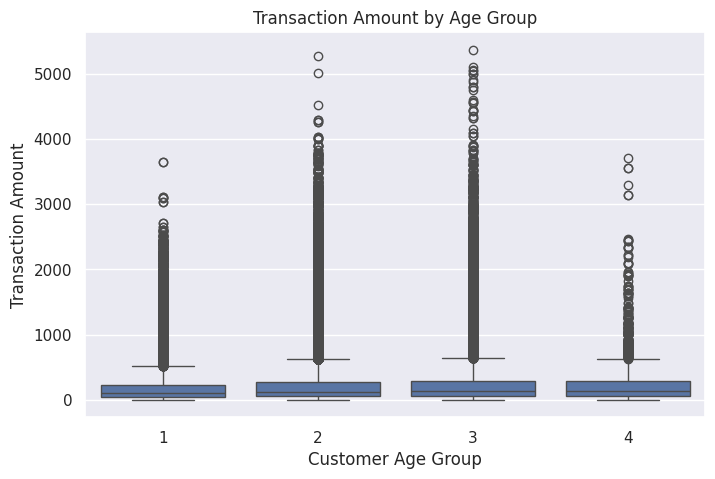

In [ ]:
plt.figure(figsize=(8, 5))
sb.boxplot(x='Customer_Age', y='Trans_Amount', data=Transformed_data)
plt.title('Transaction Amount by Age Group')
plt.xlabel('Customer Age Group')
plt.ylabel('Transaction Amount')
plt.show()

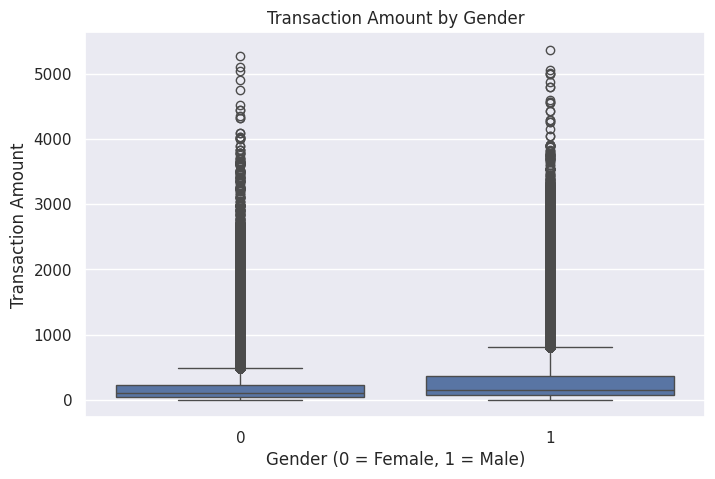

In [ ]:
plt.figure(figsize=(8, 5))
sb.boxplot(x='Gender', y='Trans_Amount', data=Transformed_data)
plt.title('Transaction Amount by Gender')
plt.xlabel('Gender (0 = Female, 1 = Male)')
plt.ylabel('Transaction Amount')
plt.show()

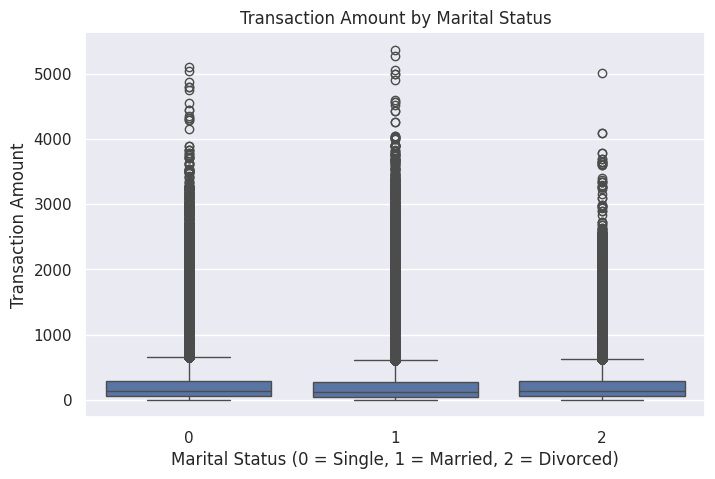

In [ ]:
plt.figure(figsize=(8, 5))
sb.boxplot(x='Marital_Status', y='Trans_Amount', data=Transformed_data)
plt.title('Transaction Amount by Marital Status')
plt.xlabel('Marital Status (0 = Single, 1 = Married, 2 = Divorced)')
plt.ylabel('Transaction Amount')
plt.show()

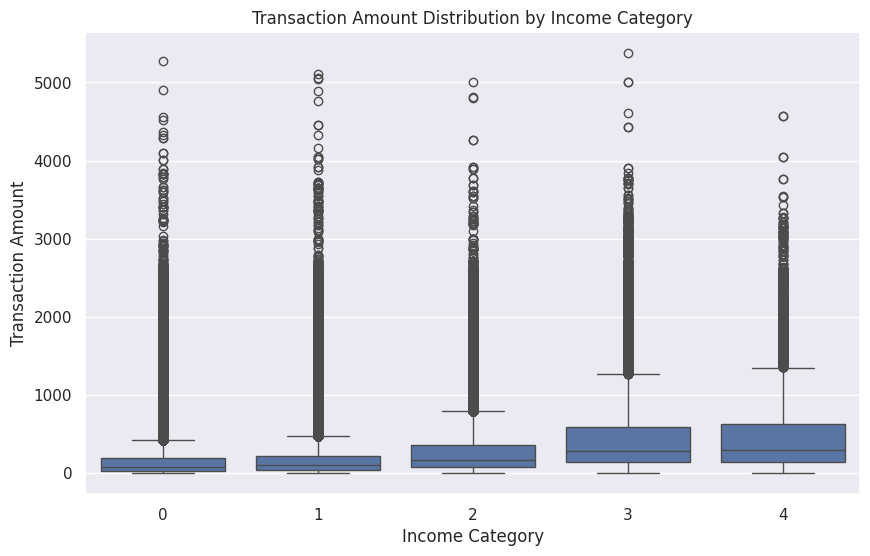

In [ ]:
plt.figure(figsize=(10, 6))
sb.boxplot(x='Income_Category', y='Trans_Amount', data=Transformed_data)
plt.title('Transaction Amount Distribution by Income Category')
plt.xlabel('Income Category')
plt.ylabel('Transaction Amount')
plt.show()

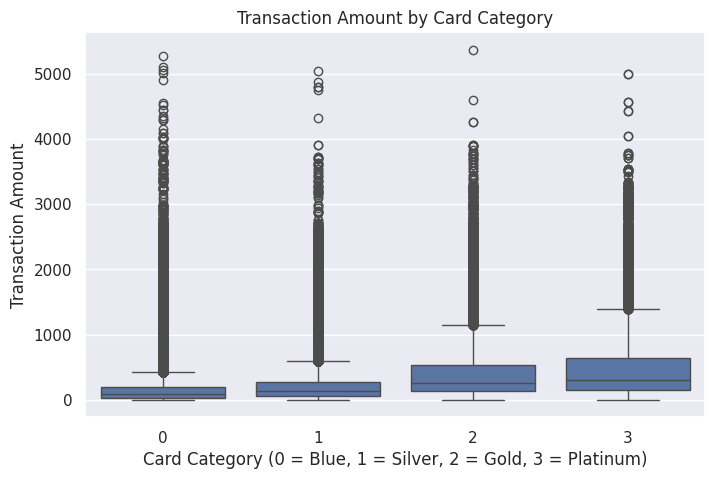

In [ ]:
plt.figure(figsize=(8, 5))
sb.boxplot(x='Card_Category_y', y='Trans_Amount', data=Transformed_data)
plt.title('Transaction Amount by Card Category')
plt.xlabel('Card Category (0 = Blue, 1 = Silver, 2 = Gold, 3 = Platinum)')
plt.ylabel('Transaction Amount')
plt.show()

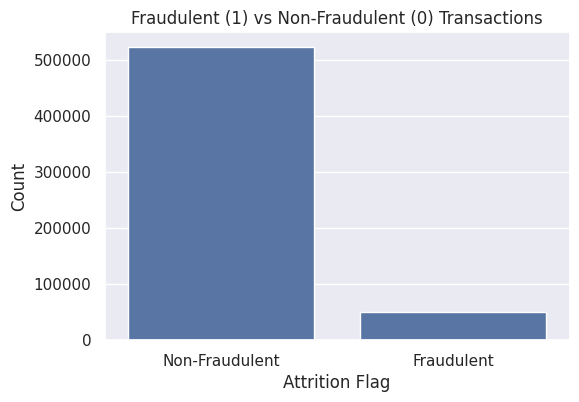

In [ ]:
plt.figure(figsize=(6, 4))
sb.countplot(x='Attrition_Flag', data=Transformed_data)
plt.title('Fraudulent (1) vs Non-Fraudulent (0) Transactions')
plt.xlabel('Attrition Flag')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])
plt.show()

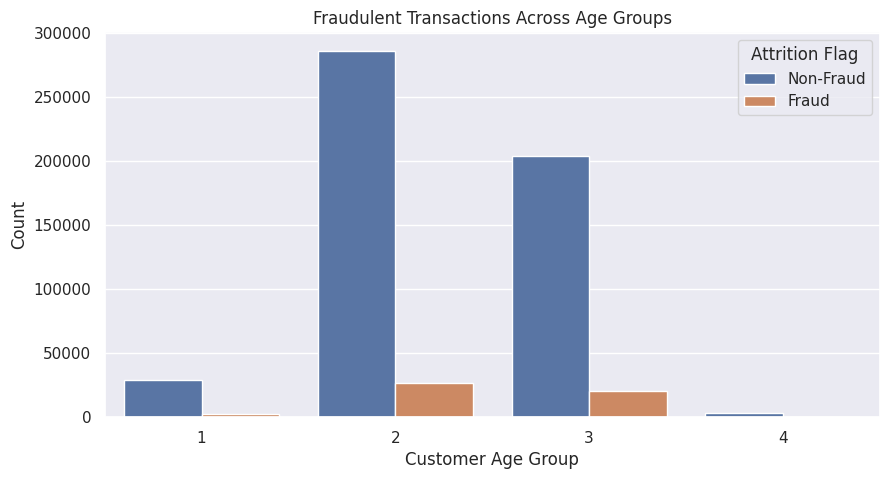

In [ ]:
plt.figure(figsize=(10, 5))
sb.countplot(x='Customer_Age', hue='Attrition_Flag', data=Transformed_data)
plt.title('Fraudulent Transactions Across Age Groups')
plt.xlabel('Customer Age Group')
plt.ylabel('Count')
plt.legend(title='Attrition Flag', labels=['Non-Fraud', 'Fraud'])
plt.show()

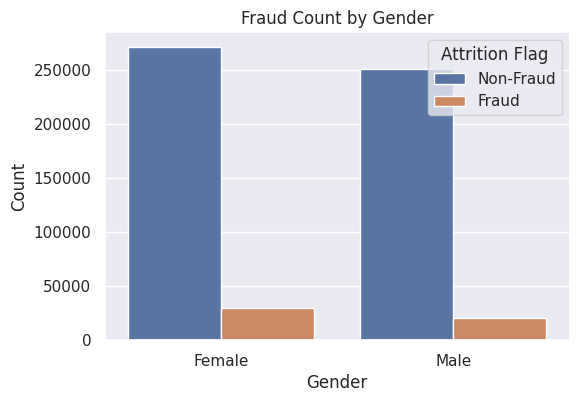

In [ ]:
plt.figure(figsize=(6, 4))
sb.countplot(x='Gender', hue='Attrition_Flag', data=Transformed_data)
plt.title('Fraud Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks([0, 1], ['Female', 'Male'])
plt.legend(title='Attrition Flag', labels=['Non-Fraud', 'Fraud'])
plt.show()

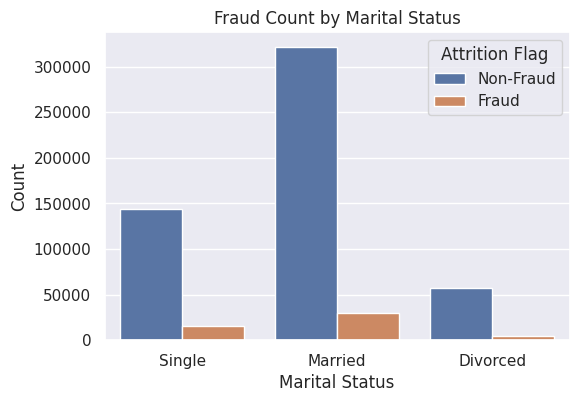

In [ ]:
plt.figure(figsize=(6, 4))
sb.countplot(x='Marital_Status', hue='Attrition_Flag', data=Transformed_data)
plt.title('Fraud Count by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['Single', 'Married', 'Divorced'])
plt.legend(title='Attrition Flag', labels=['Non-Fraud', 'Fraud'])
plt.show()

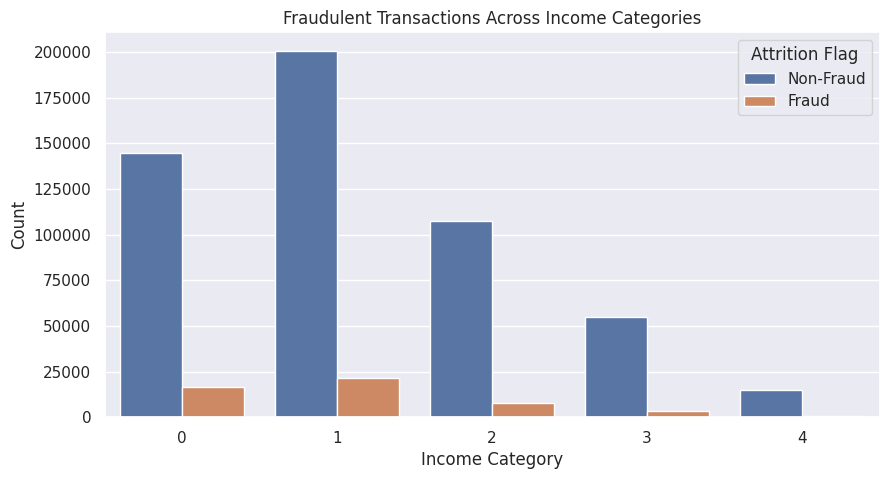

In [ ]:
plt.figure(figsize=(10, 5))
sb.countplot(x='Income_Category', hue='Attrition_Flag', data=Transformed_data)
plt.title('Fraudulent Transactions Across Income Categories')
plt.xlabel('Income Category')
plt.ylabel('Count')
plt.legend(title='Attrition Flag', labels=['Non-Fraud', 'Fraud'])
plt.show()

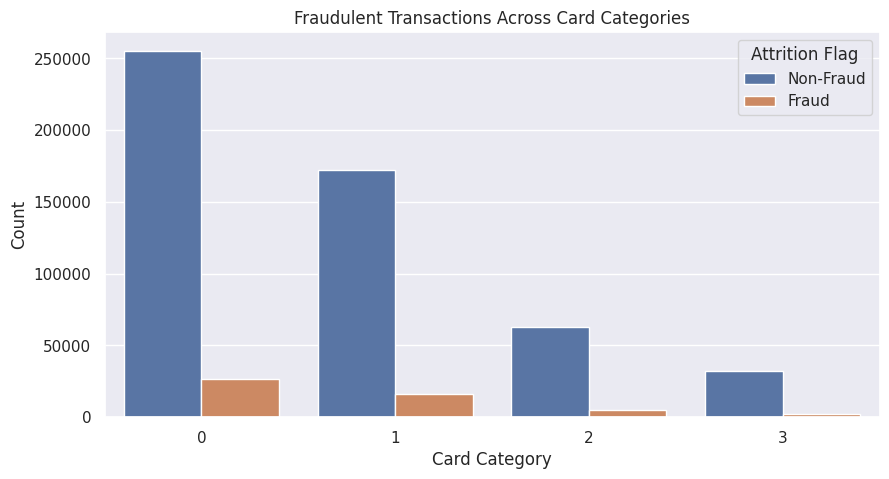

In [ ]:
plt.figure(figsize=(10, 5))
sb.countplot(x='Card_Category_y', hue='Attrition_Flag', data=Transformed_data)
plt.title('Fraudulent Transactions Across Card Categories')
plt.xlabel('Card Category')
plt.ylabel('Count')
plt.legend(title='Attrition Flag', labels=['Non-Fraud', 'Fraud'])
plt.show()

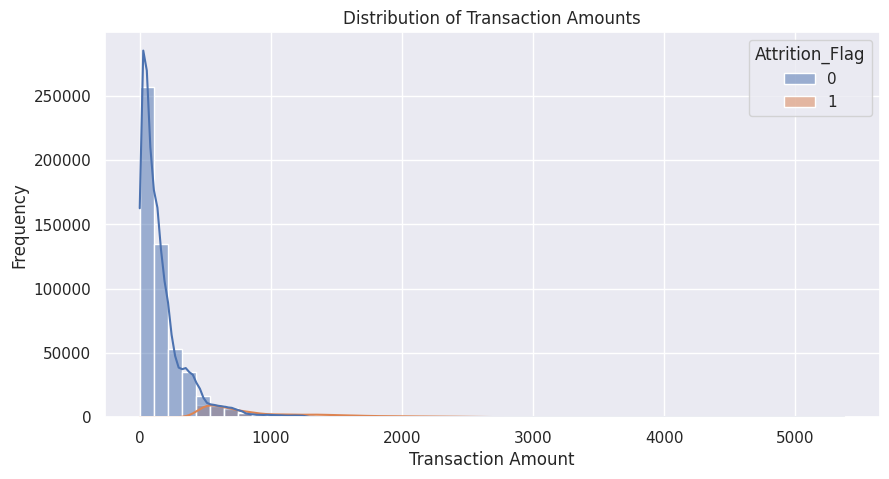

In [ ]:
plt.figure(figsize=(10, 5))
sb.histplot(data=Transformed_data, x='Trans_Amount', bins=50, hue='Attrition_Flag', kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

**5. Choosing the Best Model**

Here is the testing of the following models with the training data set:
1. Random Forest Classifier
2. Decision Tree Classifier
3. Logistic Regression
4. Naive Bayes

**5.1. Random Forest Classifier**

In [ ]:
# Check the columns of the dataset to identify the correct column names
Transformed_data.columns

Index(['Trans_Amount', 'Revenue', 'Target Revenue', 'Customer_Age', 'Gender',
       'Marital_Status', 'Income_Category', 'Card_Category_y',
       'Attrition_Flag'],
      dtype='object')

In [ ]:
# Check for missing values
Transformed_data.isnull().sum()


label_encoder = LabelEncoder()

# Encoding categorical features
Transformed_data['Attrition_Flag'] = label_encoder.fit_transform(Transformed_data['Attrition_Flag'])
Transformed_data['Gender'] = label_encoder.fit_transform(Transformed_data['Gender'])
Transformed_data['Marital_Status'] = label_encoder.fit_transform(Transformed_data['Marital_Status'])
Transformed_data['Income_Category'] = label_encoder.fit_transform(Transformed_data['Income_Category'])
Transformed_data['Card_Category_y'] = label_encoder.fit_transform(Transformed_data['Card_Category_y'])

# Handle missing values (e.g., filling with the column mean)
Transformed_data.fillna(Transformed_data.mean(), inplace=True)



# Split features and target variable
X = Transformed_data.drop(columns=['Attrition_Flag'])
y = Transformed_data['Attrition_Flag']

# Scale continuous features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Subsample the data (e.g., use 10% of the data for testing)
X_train_subsample, _, y_train_subsample, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)

# Define the parameter distribution for Random Forest
param_dist_rf = {
    'n_estimators': [50, 100],  # Use fewer trees for faster processing
    'max_depth': [10, 20],       # Shallow trees will reduce training time
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, warm_start=True)

# Perform Randomized Search with Cross-Validation (Reduced cv and n_iter)
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist_rf,
                                      n_iter=10, cv=2, n_jobs=-1, verbose=2, random_state=42)

# Fit the random search on the subsampled training data
random_search_rf.fit(X_train_subsample, y_train_subsample)

# Best parameters and best score
print("Best Parameters:", random_search_rf.best_params_)
print("Best Score:", random_search_rf.best_score_)

# Get the best model
best_rf_model = random_search_rf.best_estimator_

# Make predictions on the test set
y_pred_best = best_rf_model.predict(X_test)

# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
class_report_best = classification_report(y_test, y_pred_best)

# Display the results
accuracy_best, conf_matrix_best, class_report_best

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Best Score: 0.99934554973822


(0.9996596888334308,
 array([[104667,     13],
        [    26,   9895]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00    104680\n           1       1.00      1.00      1.00      9921\n\n    accuracy                           1.00    114601\n   macro avg       1.00      1.00      1.00    114601\nweighted avg       1.00      1.00      1.00    114601\n')

Accuracy: 0.9997

Confusion Matrix:
           Predicted: 0  Predicted: 1
Actual: 0        104667            13
Actual: 1            26          9895


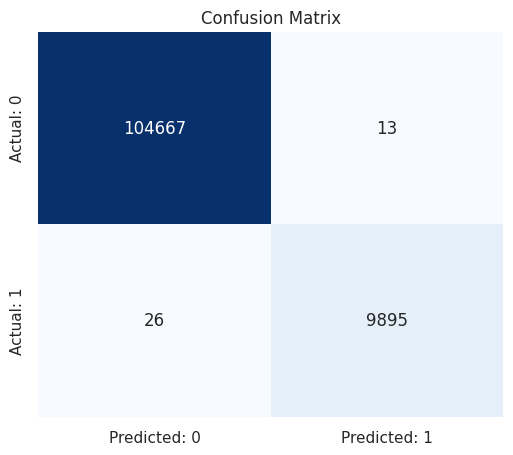


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    104680
           1       1.00      1.00      1.00      9921

    accuracy                           1.00    114601
   macro avg       1.00      1.00      1.00    114601
weighted avg       1.00      1.00      1.00    114601



In [ ]:
# Display the accuracy score
print(f"Accuracy: {accuracy_best:.4f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
conf_matrix_df = pd.DataFrame(conf_matrix_best,
                              index=["Actual: 0", "Actual: 1"],
                              columns=["Predicted: 0", "Predicted: 1"])
print(conf_matrix_df)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sb.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.show()

# Display the classification report
print("\nClassification Report:")
print(class_report_best)

**5.2. Decision Tree Classifier**

In [ ]:
# Initialize Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
class_report_dt = classification_report(y_test, y_pred_dt)

# Display the results
print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")
print(f"Confusion Matrix:\n{conf_matrix_dt}")
print(f"Classification Report:\n{class_report_dt}")

Decision Tree Accuracy: 1.0000
Confusion Matrix:
[[104680      0]
 [     0   9921]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    104680
           1       1.00      1.00      1.00      9921

    accuracy                           1.00    114601
   macro avg       1.00      1.00      1.00    114601
weighted avg       1.00      1.00      1.00    114601



Decision Tree Accuracy: 1.0000

Confusion Matrix:
           Predicted: 0  Predicted: 1
Actual: 0        104680             0
Actual: 1             0          9921


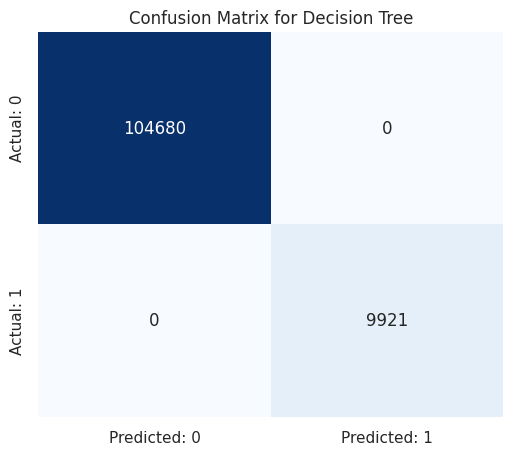


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    104680
           1       1.00      1.00      1.00      9921

    accuracy                           1.00    114601
   macro avg       1.00      1.00      1.00    114601
weighted avg       1.00      1.00      1.00    114601



In [ ]:
# Display the accuracy score
print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
conf_matrix_df = pd.DataFrame(conf_matrix_dt,
                              index=["Actual: 0", "Actual: 1"],
                              columns=["Predicted: 0", "Predicted: 1"])
print(conf_matrix_df)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sb.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Decision Tree")
plt.show()

# Display the classification report
print("\nClassification Report:")
print(class_report_dt)

**5.3. Logistic Regression**

In [ ]:
# Initialize Logistic Regression model
logreg_model = LogisticRegression(random_state=42)

# Train the model
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logreg = logreg_model.predict(X_test)

# Evaluate the model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
class_report_logreg = classification_report(y_test, y_pred_logreg)

# Display the results
print(f"Logistic Regression Accuracy: {accuracy_logreg:.4f}")
print(f"Confusion Matrix:\n{conf_matrix_logreg}")
print(f"Classification Report:\n{class_report_logreg}")

Logistic Regression Accuracy: 0.9791
Confusion Matrix:
[[103641   1039]
 [  1352   8569]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    104680
           1       0.89      0.86      0.88      9921

    accuracy                           0.98    114601
   macro avg       0.94      0.93      0.93    114601
weighted avg       0.98      0.98      0.98    114601



Logistic Regression Accuracy: 0.9791

Confusion Matrix:
           Predicted: 0  Predicted: 1
Actual: 0        103641          1039
Actual: 1          1352          8569


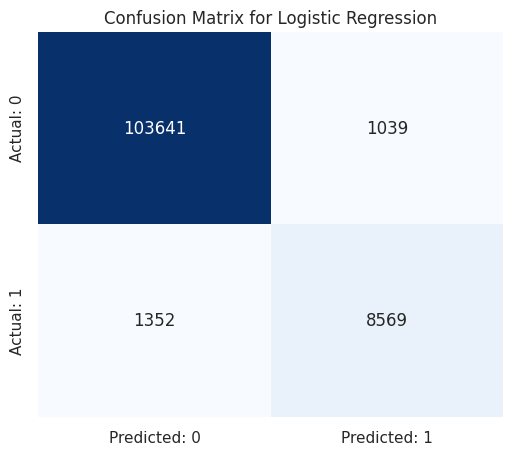


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    104680
           1       0.89      0.86      0.88      9921

    accuracy                           0.98    114601
   macro avg       0.94      0.93      0.93    114601
weighted avg       0.98      0.98      0.98    114601



In [ ]:
# Display the accuracy score
print(f"Logistic Regression Accuracy: {accuracy_logreg:.4f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
conf_matrix_df = pd.DataFrame(conf_matrix_logreg,
                              index=["Actual: 0", "Actual: 1"],
                              columns=["Predicted: 0", "Predicted: 1"])
print(conf_matrix_df)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sb.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# Display the classification report
print("\nClassification Report:")
print(class_report_logreg)

**5.4. Naive Bayes**

In [ ]:
# Initialize Naive Bayes model
nb_model = GaussianNB()

# Train the model
nb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_nb = nb_model.predict(X_test)

# Evaluate the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
class_report_nb = classification_report(y_test, y_pred_nb)

# Display the results
print(f"Naive Bayes Accuracy: {accuracy_nb:.4f}")
print(f"Confusion Matrix:\n{conf_matrix_nb}")
print(f"Classification Report:\n{class_report_nb}")

Naive Bayes Accuracy: 0.9391
Confusion Matrix:
[[99953  4727]
 [ 2251  7670]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97    104680
           1       0.62      0.77      0.69      9921

    accuracy                           0.94    114601
   macro avg       0.80      0.86      0.83    114601
weighted avg       0.95      0.94      0.94    114601



Naive Bayes Accuracy: 0.9391

Confusion Matrix:
           Predicted: 0  Predicted: 1
Actual: 0         99953          4727
Actual: 1          2251          7670


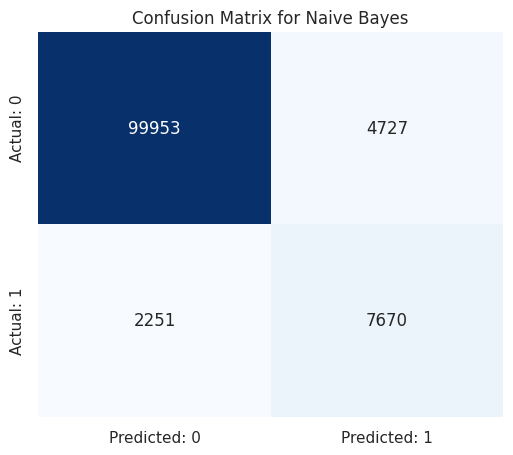


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97    104680
           1       0.62      0.77      0.69      9921

    accuracy                           0.94    114601
   macro avg       0.80      0.86      0.83    114601
weighted avg       0.95      0.94      0.94    114601



In [ ]:
# Display the accuracy score
print(f"Naive Bayes Accuracy: {accuracy_nb:.4f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
conf_matrix_df = pd.DataFrame(conf_matrix_nb,
                              index=["Actual: 0", "Actual: 1"],
                              columns=["Predicted: 0", "Predicted: 1"])
print(conf_matrix_df)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sb.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Naive Bayes")
plt.show()

# Display the classification report
print("\nClassification Report:")
print(class_report_nb)

### After Balancing



In [ ]:
# Assuming X_train and y_train are your training features and target variable
# Create a DataFrame from your training data
train_data = pd.DataFrame(X_train)
train_data['target'] = y_train

# Separate the majority and minority class
majority_class = train_data[train_data['target'] == 0]  # Non-fraudulent transactions
minority_class = train_data[train_data['target'] == 1]  # Fraudulent transactions

# Check the number of samples in both classes
print("Majority class size: ", len(majority_class))
print("Minority class size: ", len(minority_class))

# Downsample the majority class to match the minority class size
# Only do this if majority class has more samples than minority class
if len(majority_class) > len(minority_class):
    majority_class_downsampled = resample(majority_class,
                                          replace=False,  # Do not replace, only randomly sample
                                          n_samples=len(minority_class),  # Set the number of samples to match the minority class size
                                          random_state=42)  # For reproducibility
else:
    # In case the majority class has fewer or equal samples, no downsampling is needed
    majority_class_downsampled = majority_class

# Combine the downsampled majority class with the minority class
balanced_data = pd.concat([majority_class_downsampled, minority_class])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features (X) and target (y)
X_resampled = balanced_data.drop(columns=['target'])
y_resampled = balanced_data['target']

# Check the class distribution after resampling
print(f"After resampling: {Counter(y_resampled)}")


Majority class size:  327450
Minority class size:  39173
After resampling: Counter({0.0: 39173, 1.0: 39173})


RandomForest Classifier

After SMOTE: Counter({0: 417873, 1: 417873})
Random Forest Accuracy: 1.0000
Confusion Matrix:
[[104680      0]
 [     0   9921]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    104680
           1       1.00      1.00      1.00      9921

    accuracy                           1.00    114601
   macro avg       1.00      1.00      1.00    114601
weighted avg       1.00      1.00      1.00    114601

RandomTree Accuracy: 1.0000
RandomTree Precision: 1.0000
RandomTree Recall: 1.0000
RandomTree F1-Score: 1.0000

Confusion Matrix:
           Predicted: 0  Predicted: 1
Actual: 0        104680             0
Actual: 1             0          9921


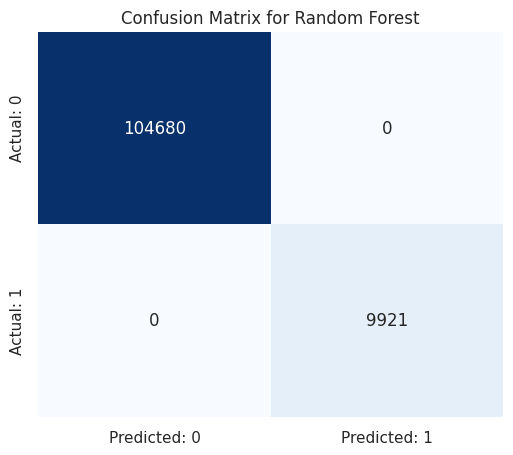


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    104680
           1       1.00      1.00      1.00      9921

    accuracy                           1.00    114601
   macro avg       1.00      1.00      1.00    114601
weighted avg       1.00      1.00      1.00    114601



In [ ]:
# Apply SMOTE to only the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after resampling (only for the training data)
print(f"After SMOTE: {Counter(y_resampled)}")

# Initialize the Random Forest Classifier
rf_model2 = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model on the resampled data
rf_model2.fit(X_resampled, y_resampled)

# Make predictions on the original test set using the trained model (rf_model2)
y_pred_rf2 = rf_model2.predict(X_test)

# Evaluate the model on the test set
accuracy_rf2 = accuracy_score(y_test, y_pred_rf2)
conf_matrix_rf2 = confusion_matrix(y_test, y_pred_rf2)
class_report_rf2 = classification_report(y_test, y_pred_rf2)

# Display the results
print(f"Random Forest Accuracy: {accuracy_rf2:.4f}")
print(f"Confusion Matrix:\n{conf_matrix_rf2}")
print(f"Classification Report:\n{class_report_rf2}")

# Extract TN, FP, FN, TP from confusion matrix
TN, FP, FN, TP = conf_matrix_rf2.ravel()

# Calculate the metrics using the confusion matrix values
accuracy2 = (TN + TP) / (TN + FP + FN + TP)
precision2 = TP / (TP + FP)  # Precision for class 1
recall2 = TP / (TP + FN)     # Recall for class 1
f1_2 = 2 * (precision2 * recall2) / (precision2 + recall2)

# Display the results
print(f"RandomTree Accuracy: {accuracy2:.4f}")
print(f"RandomTree Precision: {precision2:.4f}")
print(f"RandomTree Recall: {recall2:.4f}")
print(f"RandomTree F1-Score: {f1_2:.4f}")

# Display the confusion matrix as a DataFrame for Random Forest
conf_matrix_rf2 = confusion_matrix(y_test, y_pred_rf2)

# Convert confusion matrix to a DataFrame
conf_matrix_df_rf2 = pd.DataFrame(conf_matrix_rf2,
                                  index=["Actual: 0", "Actual: 1"],
                                  columns=["Predicted: 0", "Predicted: 1"])
print("\nConfusion Matrix:")
print(conf_matrix_df_rf2)

# Plot the confusion matrix for Random Forest
plt.figure(figsize=(6, 5))
sb.heatmap(conf_matrix_df_rf2, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Random Forest")
plt.show()

# Display the classification report for Random Forest
print("\nClassification Report:")
print(class_report_rf2)

Decision Tree Classifier

Decision Tree Accuracy: 1.0000
Confusion Matrix:
[[104680      0]
 [     0   9921]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    104680
           1       1.00      1.00      1.00      9921

    accuracy                           1.00    114601
   macro avg       1.00      1.00      1.00    114601
weighted avg       1.00      1.00      1.00    114601


Confusion Matrix:
           Predicted: 0  Predicted: 1
Actual: 0        104680             0
Actual: 1             0          9921


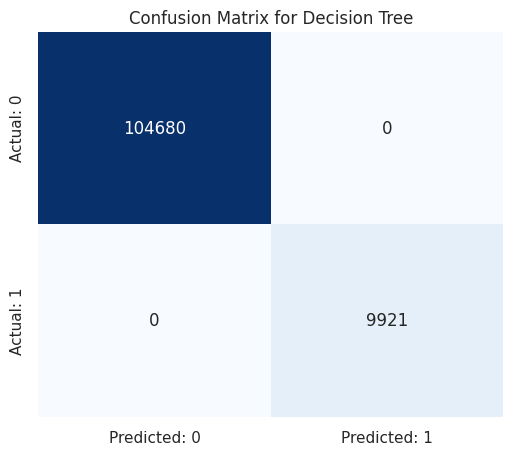


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    104680
           1       1.00      1.00      1.00      9921

    accuracy                           1.00    114601
   macro avg       1.00      1.00      1.00    114601
weighted avg       1.00      1.00      1.00    114601



In [ ]:
# Initialize the Decision Tree Classifier
dt_model2 = DecisionTreeClassifier(random_state=42)

# Train the model on the balanced training data (X_resampled, y_resampled)
dt_model2.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_dt = dt_model2.predict(X_test)

# Evaluate the model
accuracy_dt2 = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt2 = confusion_matrix(y_test, y_pred_dt)
class_report_dt2 = classification_report(y_test, y_pred_dt)

# Display the results
print(f"Decision Tree Accuracy: {accuracy_dt2:.4f}")
print(f"Confusion Matrix:\n{conf_matrix_dt2}")
print(f"Classification Report:\n{class_report_dt2}")

# Display the confusion matrix as a DataFrame
conf_matrix_df2 = pd.DataFrame(conf_matrix_dt2,
                              index=["Actual: 0", "Actual: 1"],
                              columns=["Predicted: 0", "Predicted: 1"])
print("\nConfusion Matrix:")
print(conf_matrix_df2)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sb.heatmap(conf_matrix_df2, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Decision Tree")
plt.show()

# Display the classification report
print("\nClassification Report:")
print(class_report_dt2)

Check for Overfitting

In [ ]:
rf_cv_scores = cross_val_score(rf_model2, X, y, cv=5)
dt_cv_scores = cross_val_score(dt_model2, X, y, cv=5)

print("Random Forest CV scores:", rf_cv_scores)
print("Decision Tree CV scores:", dt_cv_scores)


Random Forest CV scores: [0.99832462 0.99965096 0.99993892 0.99994764 0.99942408]
Decision Tree CV scores: [0.99990401 0.9999651  0.99998255 1.         1.        ]


The Random Forest model shows slightly lower scores compared to the Decision Tree, but the variation in performance is still quite minimal. This indicates that the Random Forest is less prone to overfitting than the Decision Tree.

The Decision Tree is achieving near-perfect accuracy, but its perfect performance across folds suggests that it could be overfitting

In [ ]:
# Make predictions on the test set
y_pred_rf = rf_model2.predict(X_test)  # Random Forest model
y_pred_dt = dt_model2.predict(X_test)  # Decision Tree model

# Evaluate both models
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Decision Tree Test Accuracy:", accuracy_score(y_test, y_pred_dt))

# Confusion Matrices
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))


Random Forest Test Accuracy: 1.0
Decision Tree Test Accuracy: 1.0
Random Forest Confusion Matrix:
[[104680      0]
 [     0   9921]]
Decision Tree Confusion Matrix:
[[104680      0]
 [     0   9921]]


Both models are achieving 100% accuracy on the test set, which means every prediction made by the models is correct

Logistic Regression

Logistic Regression Accuracy: 0.9689
Confusion Matrix:
[[101298   3382]
 [   177   9744]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    104680
           1       0.74      0.98      0.85      9921

    accuracy                           0.97    114601
   macro avg       0.87      0.97      0.91    114601
weighted avg       0.98      0.97      0.97    114601


Confusion Matrix:
           Predicted: 0  Predicted: 1
Actual: 0        101298          3382
Actual: 1           177          9744


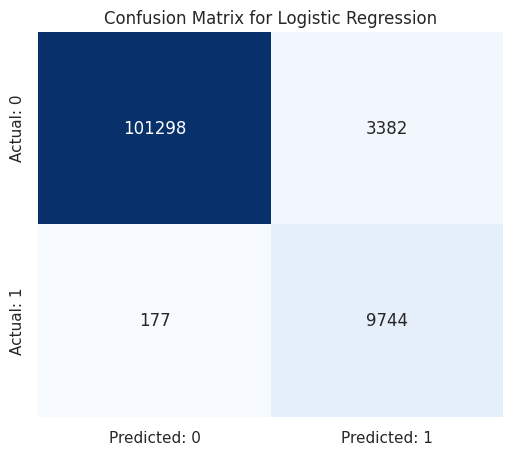


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    104680
           1       0.74      0.98      0.85      9921

    accuracy                           0.97    114601
   macro avg       0.87      0.97      0.91    114601
weighted avg       0.98      0.97      0.97    114601



In [ ]:
# Initialize the Logistic Regression model
logreg_model2 = LogisticRegression(random_state=42)

# Train the model on the balanced training data (X_resampled, y_resampled)
logreg_model2.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_logreg = logreg_model2.predict(X_test)

# Evaluate the model
accuracy_logreg2 = accuracy_score(y_test, y_pred_logreg)
conf_matrix_logreg2 = confusion_matrix(y_test, y_pred_logreg)
class_report_logreg2 = classification_report(y_test, y_pred_logreg)

# Display the results
print(f"Logistic Regression Accuracy: {accuracy_logreg2:.4f}")
print(f"Confusion Matrix:\n{conf_matrix_logreg2}")
print(f"Classification Report:\n{class_report_logreg2}")

# Display the confusion matrix as a DataFrame
conf_matrix_df2 = pd.DataFrame(conf_matrix_logreg2,
                              index=["Actual: 0", "Actual: 1"],
                              columns=["Predicted: 0", "Predicted: 1"])
print("\nConfusion Matrix:")
print(conf_matrix_df2)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sb.heatmap(conf_matrix_df2, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# Display the classification report
print("\nClassification Report:")
print(class_report_logreg2)

In [ ]:
# Extract TN, FP, FN, TP from the confusion matrix
TN_logreg, FP_logreg, FN_logreg, TP_logreg = conf_matrix_logreg.ravel()

# Calculate the metrics using the confusion matrix values
accuracy_logreg2 = (TN_logreg + TP_logreg) / (TN_logreg + FP_logreg + FN_logreg + TP_logreg)
precision_logreg2 = TP_logreg / (TP_logreg + FP_logreg)  # Precision for class 1 (fraudulent)
recall_logreg2 = TP_logreg / (TP_logreg + FN_logreg)     # Recall for class 1 (fraudulent)
f1_logreg2 = 2 * (precision_logreg2 * recall_logreg2) / (precision_logreg2 + recall_logreg2)  # F1-Score formula

# Display the results
print(f"Logistic Regression Accuracy: {accuracy_logreg2:.4f}")
print(f"Logistic Regression Precision: {precision_logreg2:.4f}")
print(f"Logistic Regression Recall: {recall_logreg2:.4f}")
print(f"Logistic Regression F1-Score: {f1_logreg2:.4f}")


Logistic Regression Accuracy: 0.9791
Logistic Regression Precision: 0.8919
Logistic Regression Recall: 0.8637
Logistic Regression F1-Score: 0.8776


Naive Bayes

Naive Bayes Accuracy: 0.9322
Confusion Matrix:
[[98004  6676]
 [ 1094  8827]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96    104680
           1       0.57      0.89      0.69      9921

    accuracy                           0.93    114601
   macro avg       0.78      0.91      0.83    114601
weighted avg       0.95      0.93      0.94    114601


Confusion Matrix:
           Predicted: 0  Predicted: 1
Actual: 0         98004          6676
Actual: 1          1094          8827


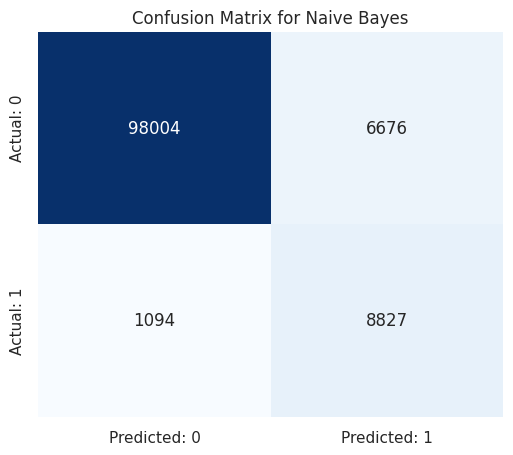


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96    104680
           1       0.57      0.89      0.69      9921

    accuracy                           0.93    114601
   macro avg       0.78      0.91      0.83    114601
weighted avg       0.95      0.93      0.94    114601



In [ ]:
# Initialize Naive Bayes model
nb_model2 = GaussianNB()

# Train the model on the balanced training data (X_resampled, y_resampled)
nb_model2.fit(X_resampled, y_resampled)

# Make predictions on the test set (which remains unchanged)
y_pred_nb = nb_model2.predict(X_test)

# Evaluate the model
accuracy_nb2 = accuracy_score(y_test, y_pred_nb)
conf_matrix_nb2 = confusion_matrix(y_test, y_pred_nb)
class_report_nb2 = classification_report(y_test, y_pred_nb)

# Display the results
print(f"Naive Bayes Accuracy: {accuracy_nb2:.4f}")
print(f"Confusion Matrix:\n{conf_matrix_nb2}")
print(f"Classification Report:\n{class_report_nb2}")

# Display the confusion matrix as a DataFrame
conf_matrix_df2 = pd.DataFrame(conf_matrix_nb2,
                              index=["Actual: 0", "Actual: 1"],
                              columns=["Predicted: 0", "Predicted: 1"])
print("\nConfusion Matrix:")
print(conf_matrix_df2)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sb.heatmap(conf_matrix_df2, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Naive Bayes")
plt.show()

# Display the classification report
print("\nClassification Report:")
print(class_report_nb2)

In [ ]:
# Extract TN, FP, FN, TP from the confusion matrix for Naive Bayes
TN_nb, FP_nb, FN_nb, TP_nb = conf_matrix_nb.ravel()

# Calculate the metrics using the confusion matrix values for Naive Bayes
accuracy_nb2 = (TN_nb + TP_nb) / (TN_nb + FP_nb + FN_nb + TP_nb)
precision_nb2 = TP_nb / (TP_nb + FP_nb)  # Precision for class 1 (fraudulent)
recall_nb2 = TP_nb / (TP_nb + FN_nb)     # Recall for class 1 (fraudulent)
f1_nb2 = 2 * (precision_nb2 * recall_nb2) / (precision_nb2 + recall_nb2)  # F1-Score formula

# Display the results for Naive Bayes
print(f"Naive Bayes Accuracy: {accuracy_nb2:.4f}")
print(f"Naive Bayes Precision: {precision_nb2:.4f}")
print(f"Naive Bayes Recall: {recall_nb2:.4f}")
print(f"Naive Bayes F1-Score: {f1_nb2:.4f}")


Naive Bayes Accuracy: 0.9391
Naive Bayes Precision: 0.6187
Naive Bayes Recall: 0.7731
Naive Bayes F1-Score: 0.6873


Select best model

In [ ]:
print(f"RandomTree Accuracy: {accuracy2:.4f}")
print(f"RandomTree Precision: {precision2:.4f}")
print(f"RandomTree Recall: {recall2:.4f}")
print(f"RandomTree F1-Score: {f1_2:.4f}")

print(f"Logistic Regression Accuracy: {accuracy_logreg2:.4f}")
print(f"Logistic Regression Precision: {precision_logreg2:.4f}")
print(f"Logistic Regression Recall: {recall_logreg2:.4f}")
print(f"Logistic Regression F1-Score: {f1_logreg2:.4f}")

print(f"Naive Bayes Accuracy: {accuracy_nb2:.4f}")
print(f"Naive Bayes Precision: {precision_nb2:.4f}")
print(f"Naive Bayes Recall: {recall_nb2:.4f}")
print(f"Naive Bayes F1-Score: {f1_nb2:.4f}")

RandomTree Accuracy: 1.0000
RandomTree Precision: 1.0000
RandomTree Recall: 1.0000
RandomTree F1-Score: 1.0000
Logistic Regression Accuracy: 0.9791
Logistic Regression Precision: 0.8919
Logistic Regression Recall: 0.8637
Logistic Regression F1-Score: 0.8776
Naive Bayes Accuracy: 0.9391
Naive Bayes Precision: 0.6187
Naive Bayes Recall: 0.7731
Naive Bayes F1-Score: 0.6873


Why Focus on Precision, Recall, and F1-Score?

In imbalanced datasets, accuracy is often misleading because the model can achieve high accuracy by simply predicting the majority class. For example, in fraud detection, predicting all transactions as non-fraudulent could still result in high accuracy but wouldn't be useful.

Recall is especially important because we don't want to miss any fraudulent transactions, which can have serious consequences (financial loss, fraud).

F1-Score balances precision and recall, and it is particularly useful when you want to find a trade-off between the two.

####**Regression**

Correlation matrix (Heatmap):


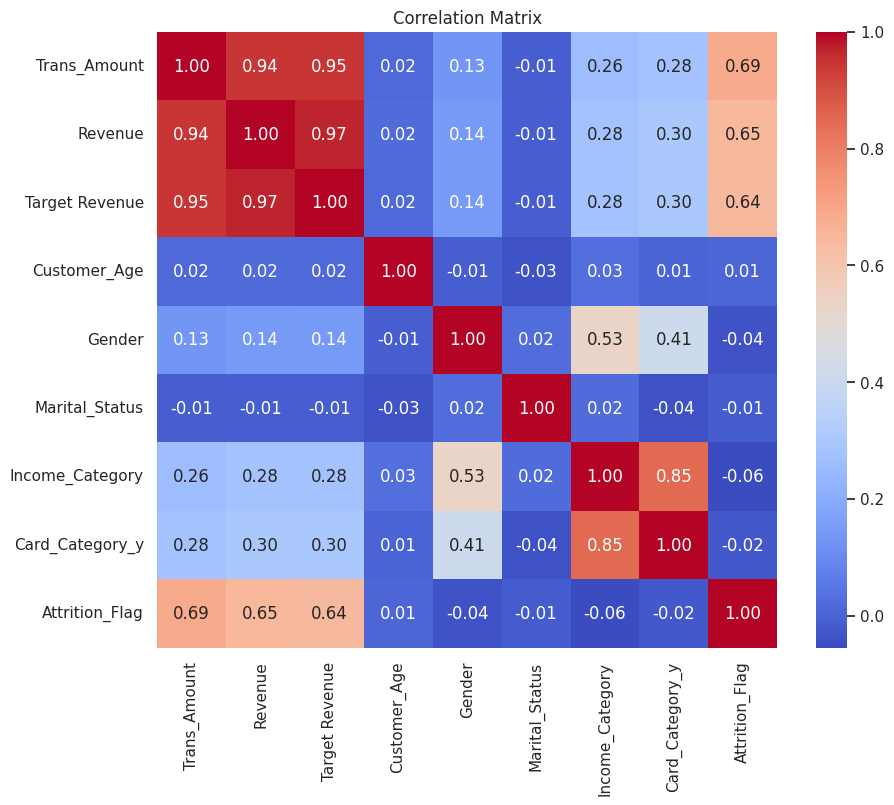

In [ ]:
# Calculate the correlation matrix
correlation_matrix = Transformed_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


Pulling out the top 2(Excluding Attrition Flag) since everything below 0.3 except 2:


In [ ]:
# Calculate correlation matrix for 'Trans_Amount', 'Revenue', and 'Target Revenue'
correlation_matrix = Transformed_data[['Trans_Amount', 'Revenue', 'Target Revenue']].corr()

# Display the correlation matrix
print(correlation_matrix)



                Trans_Amount   Revenue  Target Revenue
Trans_Amount        1.000000  0.942498        0.945268
Revenue             0.942498  1.000000        0.970323
Target Revenue      0.945268  0.970323        1.000000



Doing a scatter plot(individually) for both the features against Trans_Amount:



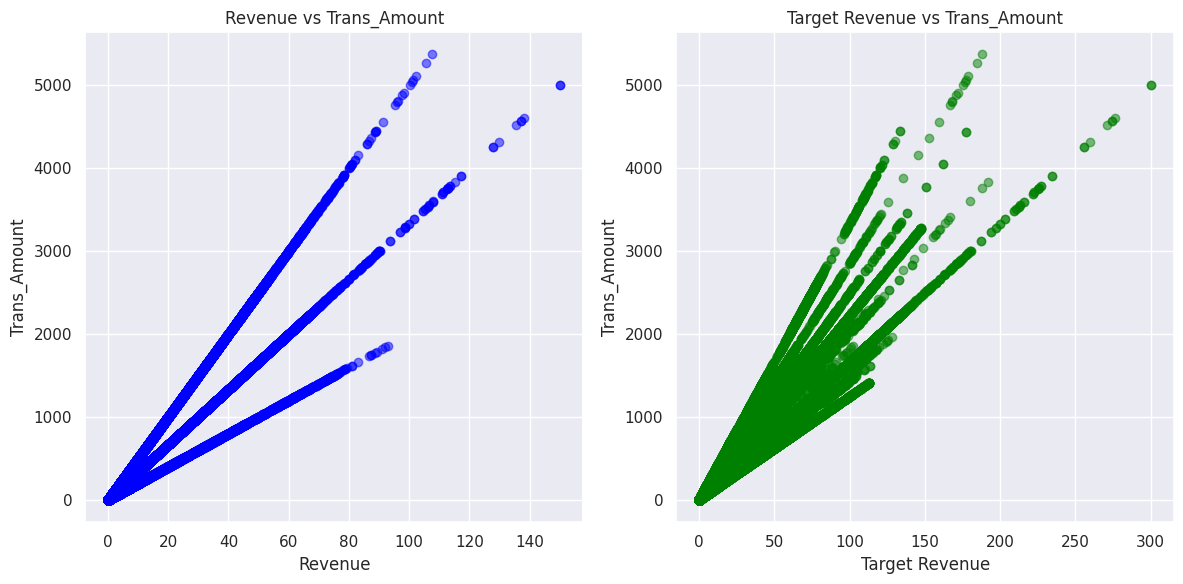

In [ ]:
# Scatter plot for Revenue vs Trans_Amount
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(Transformed_data['Revenue'], Transformed_data['Trans_Amount'], alpha=0.5, color='blue')
plt.title('Revenue vs Trans_Amount')
plt.xlabel('Revenue')
plt.ylabel('Trans_Amount')

# Scatter plot for Target Revenue vs Trans_Amount
plt.subplot(1, 2, 2)
plt.scatter(Transformed_data['Target Revenue'], Transformed_data['Trans_Amount'], alpha=0.5, color='green')
plt.title('Target Revenue vs Trans_Amount')
plt.xlabel('Target Revenue')
plt.ylabel('Trans_Amount')

plt.tight_layout()
plt.show()


Checking linearity with Pearson:

In [ ]:
# Check linear correlation between Revenue and Trans_Amount
rev_corr = Transformed_data['Revenue'].corr(Transformed_data['Trans_Amount'])

# Check linear correlation between Target Revenue and Trans_Amount
target_corr = Transformed_data['Target Revenue'].corr(Transformed_data['Trans_Amount'])

print(f"Correlation (Revenue vs Trans_Amount): {rev_corr:.3f}")
print(f"Correlation (Target Revenue vs Trans_Amount): {target_corr:.3f}")

Correlation (Revenue vs Trans_Amount): 0.942
Correlation (Target Revenue vs Trans_Amount): 0.945


Thus, since relationship between the variables looks(visually) like a straight line or close to one in the scatter plot, as well as having both the correlation coefficient(r) of more than 0.94, linear regression may be appropriate and SVR linear appropriate(non-linear SVR not appropriate)
Random Forest Regressor does not care whether the relationship between features and the target is linear or non-linear.
**bold text**

**Regression Models**

1) Linear Regression

In [ ]:
#Linear Regression, with MSE, R^2


X = Transformed_data.drop(columns=['Trans_Amount', 'Attrition_Flag', 'Card_Category_y', 'Marital_Status','Customer_Age', 'Gender',  'Income_Category'])  # Features
y = Transformed_data['Trans_Amount']  # Target variable (Trans_Amount)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make Predictions
y_pred = lr_model.predict(X_test)

#  Evaluate the Model
mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


# Print evaluation metrics
print(f"Linear Regression Results:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")




Linear Regression Results:
Mean Squared Error (MSE): 10415.24
R² Score: 0.9053


Plot actual vs Predicted(Linear Regression):

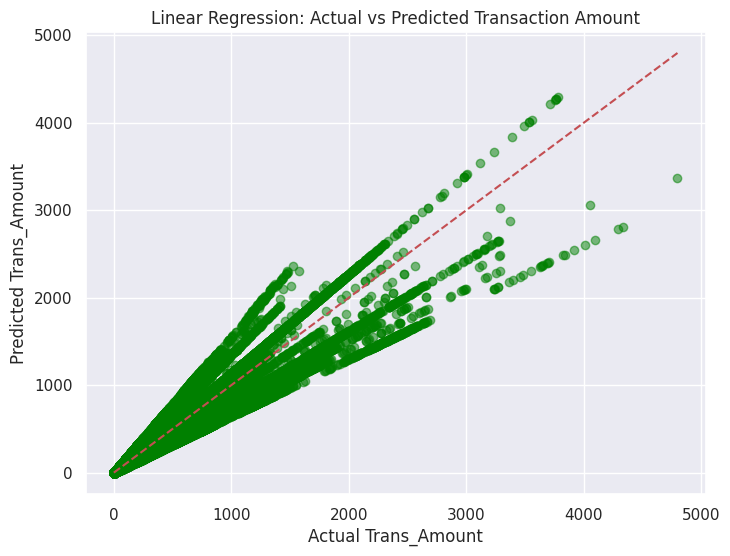

In [ ]:
# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Trans_Amount")
plt.ylabel("Predicted Trans_Amount")
plt.title("Linear Regression: Actual vs Predicted Transaction Amount")
plt.grid(True)
plt.show()


2) Support Vector Regression (SVR):

Sample size of 1000 for speed

In [ ]:

#Sample data for speed
sample_data = Transformed_data[['Revenue', 'Target Revenue', 'Trans_Amount']].sample(1000, random_state=42)

# Define features and target
X = sample_data[['Revenue', 'Target Revenue']]
y = sample_data['Trans_Amount']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train fast SVR model
svr_fast = SVR(kernel='linear', C=10, epsilon=1.0)  # Adjust C/epsilon for tradeoff between speed and accuracy
svr_fast.fit(X_train, y_train)

# Predict & evaluate
y_pred = svr_fast.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"SVR (Trans_Amount) MSE: {mse:.2f}")
print(f"SVR (Trans_Amount) R² Score: {r2:.2f}")


SVR (Trans_Amount) MSE: 11614.44
SVR (Trans_Amount) R² Score: 0.89


CROSS VALIDATION BY K-FOLDS MEANS(to prevent bias & overfitting issues due to sample size)


In [ ]:
# K-Fold on SVR(1000)



from sklearn.model_selection import cross_val_score


# Sample the data (1000 samples)
sample_data = Transformed_data[['Revenue', 'Target Revenue', 'Trans_Amount']].sample(1000, random_state=42)

# Define features and target
X = sample_data[['Revenue', 'Target Revenue']]
y = sample_data['Trans_Amount']

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Apply K-Fold Cross Validation
svr = SVR(kernel='linear', C=10, epsilon=1.0)  # Adjust parameters as needed

# Perform 5-fold cross-validation
cv_scores = cross_val_score(svr, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(svr, X_scaled, y, cv=5, scoring='r2')

# Print the results
print(f"K-Fold Cross-Validation (5 folds) R²: {cv_scores_r2}")
print(f"Average R²: {cv_scores_r2.mean()}")


K-Fold Cross-Validation (5 folds) R²: [0.90731054 0.94927859 0.84516667 0.87540818 0.93096353]
Average R²: 0.9016255005639486


K folds R^2 (average) very close to SVR R^2. So not biased and overfitted.


Plot Actual vs Predicted(SVR):


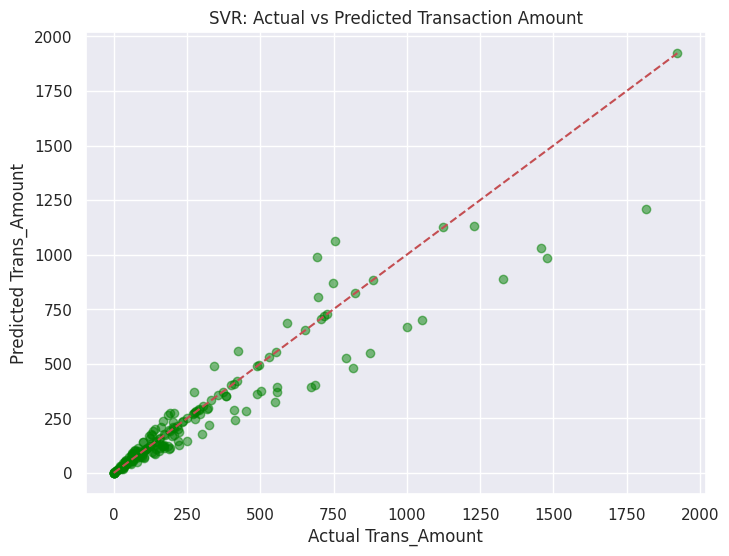

In [ ]:
# plot for SVR Actual vs Predicted Transaction Amount
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Trans_Amount")
plt.ylabel("Predicted Trans_Amount")
plt.title("SVR: Actual vs Predicted Transaction Amount")
plt.grid(True)
plt.show()



3) Random Forest Regression:


In [ ]:
feature = ['Revenue', 'Target Revenue', 'Customer_Age', 'Gender', 'Marital_Status', 'Income_Category', 'Card_Category_y' ]
target = 'Trans_Amount'  # Target variable, e.g., predicting transaction amounts

# Define the features and target
X = Transformed_data[feature]
y = Transformed_data[target]

# === 2. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 3. Initialize and Train Model ===
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

# === 4. Predict on Test Set ===
y_pred = model.predict(X_test)

# === 5. Evaluation Metrics ===
mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)



print(f"Random Forest Regressor-")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")


Random Forest Regressor-
Mean Squared Error (MSE): 891.21
R² Score: 0.9919



Plot Actual vs Predicted(Random Forest Regression):

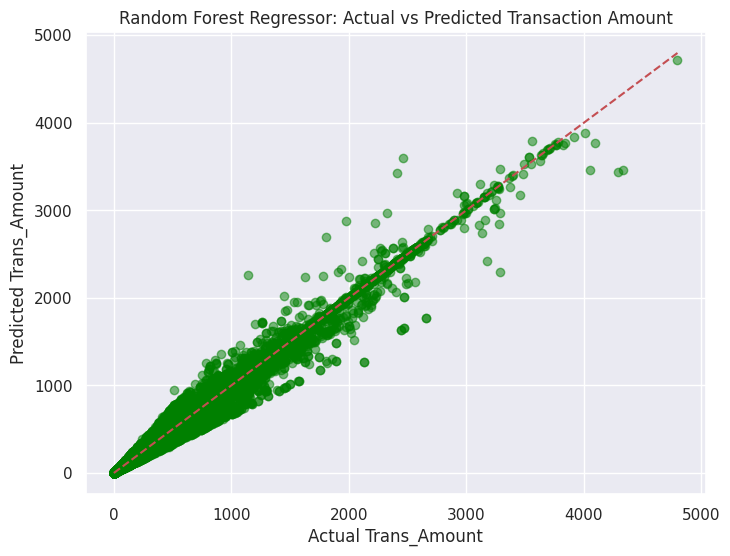

In [ ]:
# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Trans_Amount")
plt.ylabel("Predicted Trans_Amount")
plt.title("Random Forest Regressor: Actual vs Predicted Transaction Amount")
plt.grid(True)
plt.show()


Feature Importance:

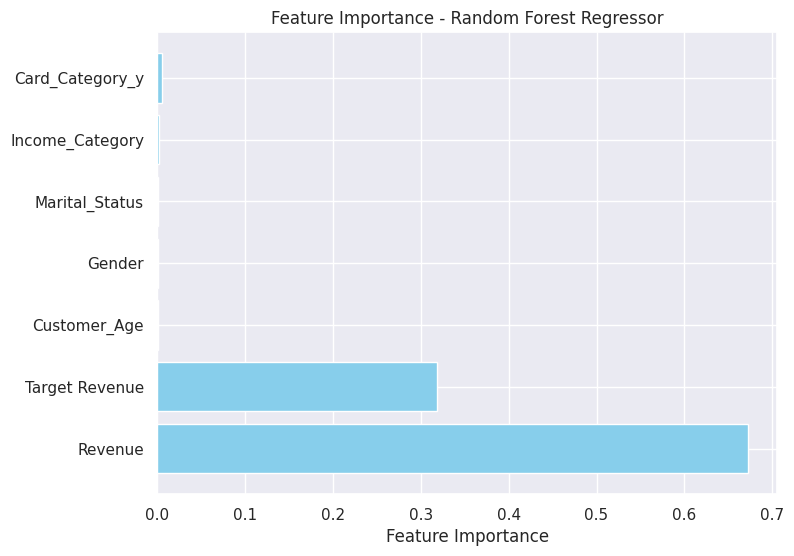

In [ ]:
# Feature Importance Plot
# Plot the feature importance from the Random Forest model
feature_importance = model.feature_importances_
plt.figure(figsize=(8, 6))
plt.barh(feature, feature_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance - Random Forest Regressor")
plt.show()


From feature importance the best predictors are: Target revenue and Revenue


3a) Random Forest Regressor, after feature importance

In [ ]:
feature = ['Revenue', 'Target Revenue' ]
target = 'Trans_Amount'  # Target variable, e.g., predicting transaction amounts

# Define the features and target
X = Transformed_data[feature]
y = Transformed_data[target]

# === 2. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 3. Initialize and Train Model ===
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

# === 4. Predict on Test Set ===
y_pred = model.predict(X_test)

# === 5. Evaluation Metrics ===
mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)



print(f"Random Forest Regressor-")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")



Random Forest Regressor-
Mean Squared Error (MSE): 1016.77
R² Score: 0.9908


Results:

Linear Regression Results:
Mean Squared Error (MSE): 10415.24
R² Score: 0.9053

SVR (Trans_Amount) MSE: 11614.44
SVR (Trans_Amount) R² Score: 0.89

Random Forest Regressor(after feature importance)-
Mean Squared Error (MSE): 1016.77
R² Score: 0.9908


Best Model is Random Forest Regressor. It has the lowest MSE, much lower than the other 2 models. And this indicates error is much smaller than the others.
Furthermore, it has the highest R^2 value of 0.9908, so it explains 99% of the variance in Trans_Amount. Which is extremely strong.



Another point to note is that It can handle both linear and non-linear relationships really well.


**Conclusion: Random Forest Regression is the best among the Regression models.**

Cross Validation Random Forest Regressor(similar to k fold cross validation):




In [ ]:
# Define the features and target
X = Transformed_data[['Revenue', 'Target Revenue']]
y = Transformed_data['Trans_Amount']

# Initialize RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE to positive MSE
cv_scores = -cv_scores

# Calculate mean MSE from cross-validation scores
mean_mse = cv_scores.mean()

# Print evaluation metrics from cross-validation
print(f"Cross-Validation Mean MSE: {mean_mse:.2f}")

# Train model on entire dataset to get final metrics
model.fit(X, y)

# Predict on the entire dataset
y_pred = model.predict(X)

# Evaluate final model
mse = mean_squared_error(y, y_pred)

r2 = r2_score(y, y_pred)


# Print final evaluation metrics
print(f"Random Forest Regressor Final Results:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")


Cross-Validation Mean MSE: 21590.80
Random Forest Regressor Final Results:
Mean Squared Error (MSE): 109.37
R² Score: 0.9990


Hyperparameter Tunning of Random Forest Regressor:

In [ ]:
# Define the hyperparameters grid to search over
param_grid = {
    'n_estimators': [50, 100, 150],               # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],               # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],               # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                 # Minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],     # Number of features to consider when looking for the best split
    'bootstrap': [True, False]                     # Whether bootstrap samples are used when building trees
}

# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)

# Initialize the GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Print the best parameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Predict on the test set using the best model
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"Random Forest Regressor with Hyperparameter Tuning:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")


**6. Finding Individual Predictor That Best Predict Fraud**

**BEST MODEL: Random Forest Classification**

In [ ]:
# Splitting the dataset into predictors and target
predictors = Transformed_data.drop(['Attrition_Flag'], axis=1)
target = Transformed_data['Attrition_Flag']

# Splitting dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size = 0.22, random_state = 0)

Transformed_train_data = pd.concat([x_train, y_train], axis=1)
Transformed_test_data = pd.concat([x_test, y_test], axis=1)
Transformed_test_data.head()

,Trans_Amount,Revenue,Target Revenue,Customer_Age,Gender,Marital_Status,Income_Category,Card_Category_y,Attrition_Flag
357938,2050.6500,61.51950,123.039000,3,0,1,1,0,1
329872,205.6950,6.17085,13.370175,3,1,1,1,0,0
54285,786.0825,15.72165,23.582475,3,0,1,0,0,1
559568,34.6712,1.73356,2.357642,3,1,1,2,1,0
43036,133.0350,2.66070,3.991050,2,0,2,1,1,0


In [ ]:
# Creating a function producing Confusion Matrix and additional metrics
def confusionMatrix(x_train, y_train, x_test, y_test, model):
    # Predictions for train and test
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Classification Accuracy
    acc_model = round(accuracy_score(y_test_pred, y_test) * 100, 2)

    # Confusion matrix for train and test
    f, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=600)
    sb.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt=".0f", annot_kws={"size": 18}, ax=axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt=".0f", annot_kws={"size": 18}, ax=axes[1])

    # For Train Data
    CM_train = confusion_matrix(y_train, y_train_pred)
    TN_train = CM_train[0][0]
    FN_train = CM_train[1][0]
    TP_train = CM_train[1][1]
    FP_train = CM_train[0][1]
    TPR_train = TP_train / (TP_train + FN_train)  # True Positive Rate
    FPR_train = FP_train / (FP_train + TN_train)  # False Positive Rate
    Precision_train = precision_score(y_train, y_train_pred)  # Precision for Train
    Recall_train = recall_score(y_train, y_train_pred)  # Recall for Train
    F1_train = f1_score(y_train, y_train_pred)  # F1 Score for Train

    # For Test Data
    CM_test = confusion_matrix(y_test, y_test_pred)
    TN_test = CM_test[0][0]
    FN_test = CM_test[1][0]
    TP_test = CM_test[1][1]
    FP_test = CM_test[0][1]
    TPR_test = TP_test / (TP_test + FN_test)  # True Positive Rate
    FPR_test = FP_test / (FP_test + TN_test)  # False Positive Rate
    Precision_test = precision_score(y_test, y_test_pred)  # Precision for Test
    Recall_test = recall_score(y_test, y_test_pred)  # Recall for Test
    F1_test = f1_score(y_test, y_test_pred)  # F1 Score for Test

    # Print Metrics
    print("Classification Accuracy in train data \t:", model.score(x_train, y_train))
    print("Train Data - True Positive Rate \t:", TPR_train)
    print("Train Data - False Positive Rate \t:", FPR_train)
    print("Train Data - Precision \t:", Precision_train)
    print("Train Data - Recall \t:", Recall_train)
    print("Train Data - F1 Score \t:", F1_train)

    print("\nClassification Accuracy in test data \t:", model.score(x_test, y_test))
    print("Test Data - True Positive Rate \t:", TPR_test)
    print("Test Data - False Positive Rate \t:", FPR_test)
    print("Test Data - Precision \t:", Precision_test)
    print("Test Data - Recall \t:", Recall_test)
    print("Test Data - F1 Score \t:", F1_test)

    plt.show()

    return acc_model

In [ ]:
# Select features and target
x = Transformed_train_data[["Customer_Age", "Gender", "Income_Category"]].copy()
y = Transformed_train_data["Attrition_Flag"]

# Split into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.25, random_state=0)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)

Classification Accuracy in train data 	: 0.5067288631263535
Train Data - True Positive Rate 	: 0.4100975472525172
Train Data - False Positive Rate 	: 0.39663982099981027
Train Data - Precision 	: 0.508340834813355
Train Data - Recall 	: 0.4100975472525172
Train Data - F1 Score 	: 0.4539647593044561

Classification Accuracy in test data 	: 0.5870176129447985
Test Data - True Positive Rate 	: 0.410378312765527
Test Data - False Positive Rate 	: 0.39583701521845854
Test Data - Precision 	: 0.09142947287765082
Test Data - Recall 	: 0.410378312765527
Test Data - F1 Score 	: 0.149542011463536


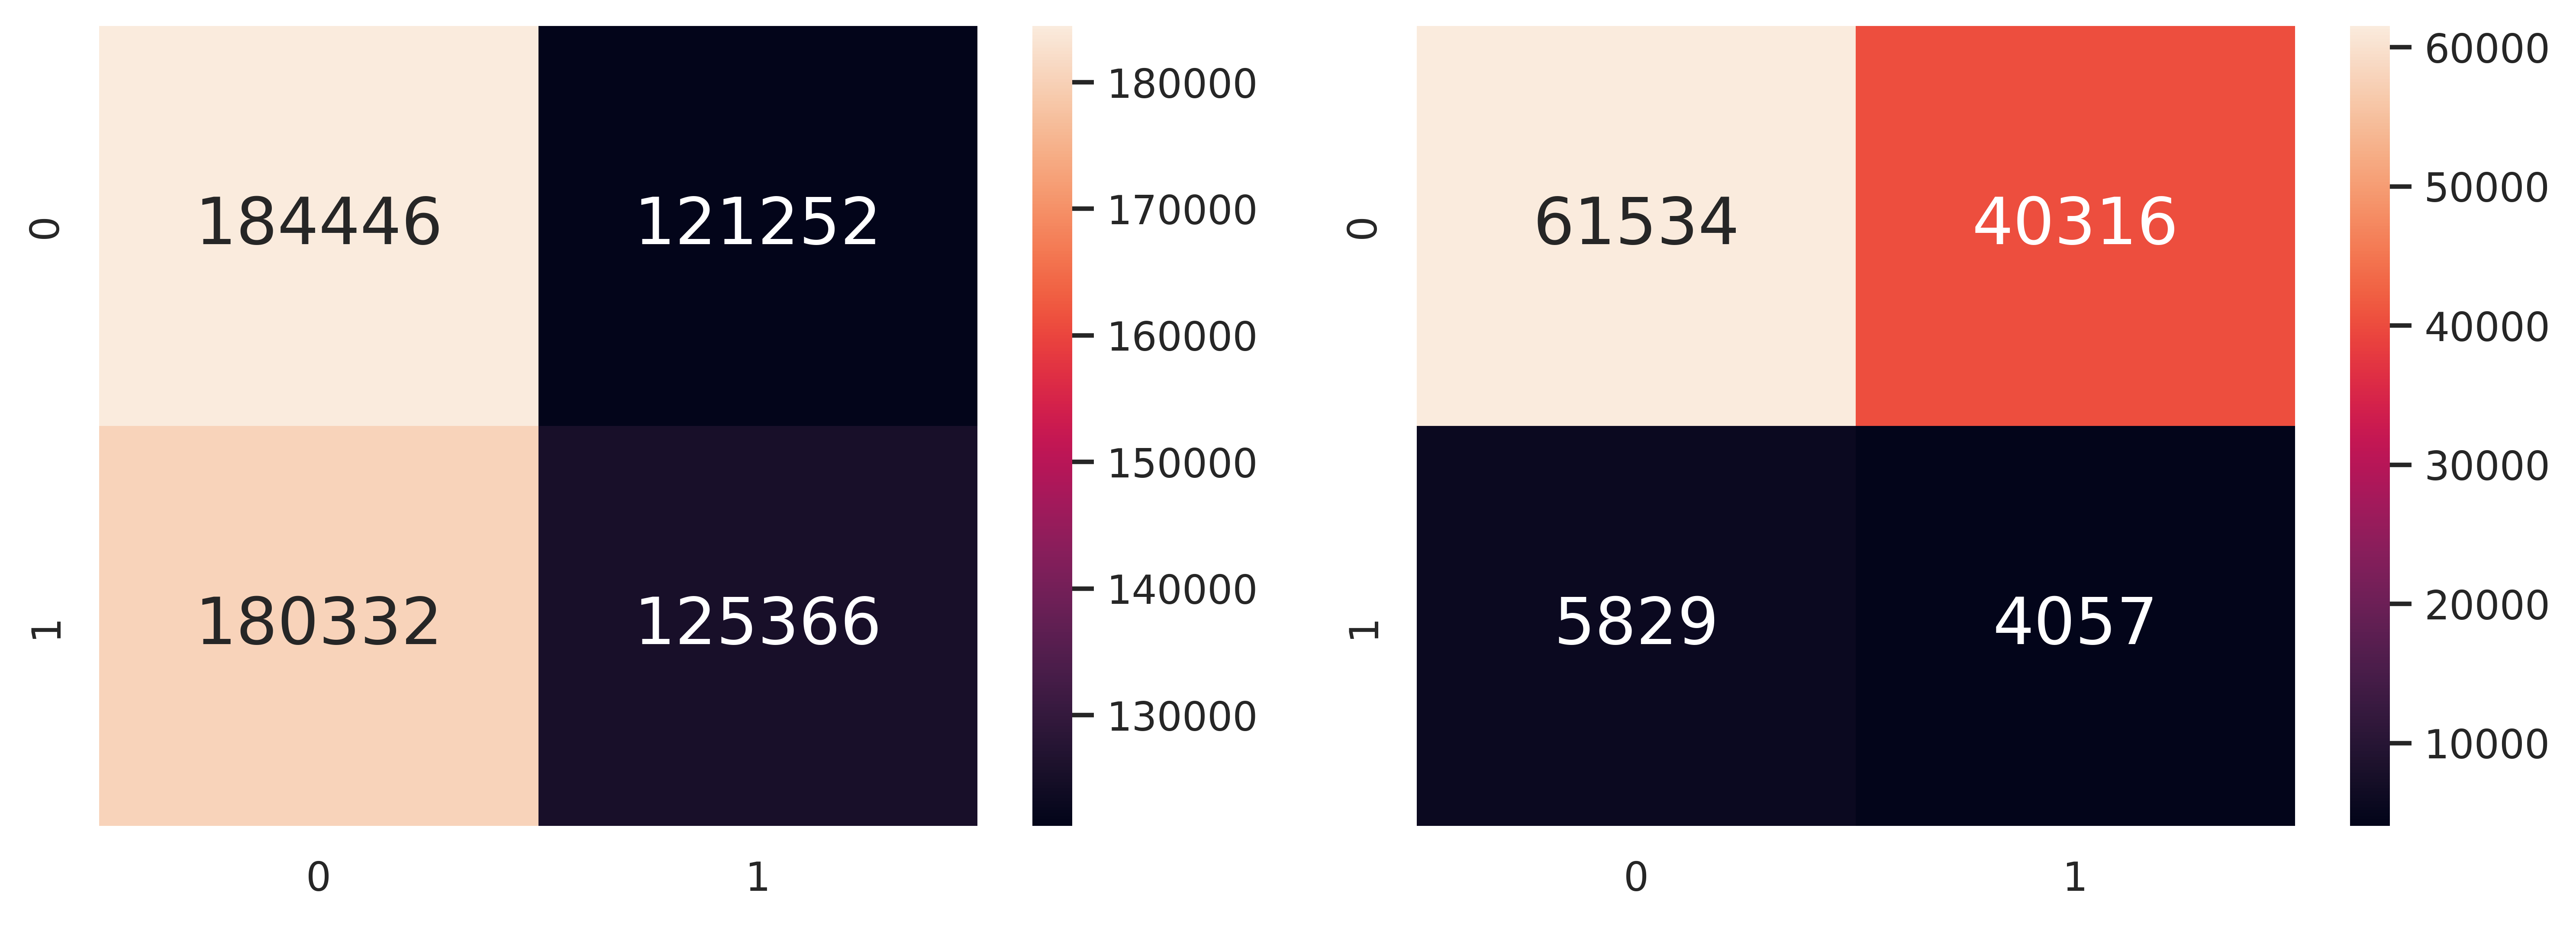

58.7

In [ ]:
# Select only 'Customer_Age'
Customer_Age_train_smote = pd.DataFrame(X_train_smote["Customer_Age"])
Customer_Age_test = pd.DataFrame(X_test["Customer_Age"])

# Train
randomforest_age = RandomForestClassifier(random_state=0)
randomforest_age.fit(Customer_Age_train_smote, Y_train_smote)

# Evaluate
confusionMatrix(Customer_Age_train_smote, Y_train_smote, Customer_Age_test, Y_test, randomforest_age)

Classification Accuracy in train data 	: 0.532190266210443
Train Data - True Positive Rate 	: 0.5839652205771709
Train Data - False Positive Rate 	: 0.519584688156285
Train Data - Precision 	: 0.5291697420802542
Train Data - Recall 	: 0.5839652205771709
Train Data - F1 Score 	: 0.5552187929106711

Classification Accuracy in test data 	: 0.4908176415837331
Test Data - True Positive Rate 	: 0.5913412907141412
Test Data - False Positive Rate 	: 0.518939617083947
Test Data - Precision 	: 0.09959114139693356
Test Data - Recall 	: 0.5913412907141412
Test Data - F1 Score 	: 0.17047210801038112


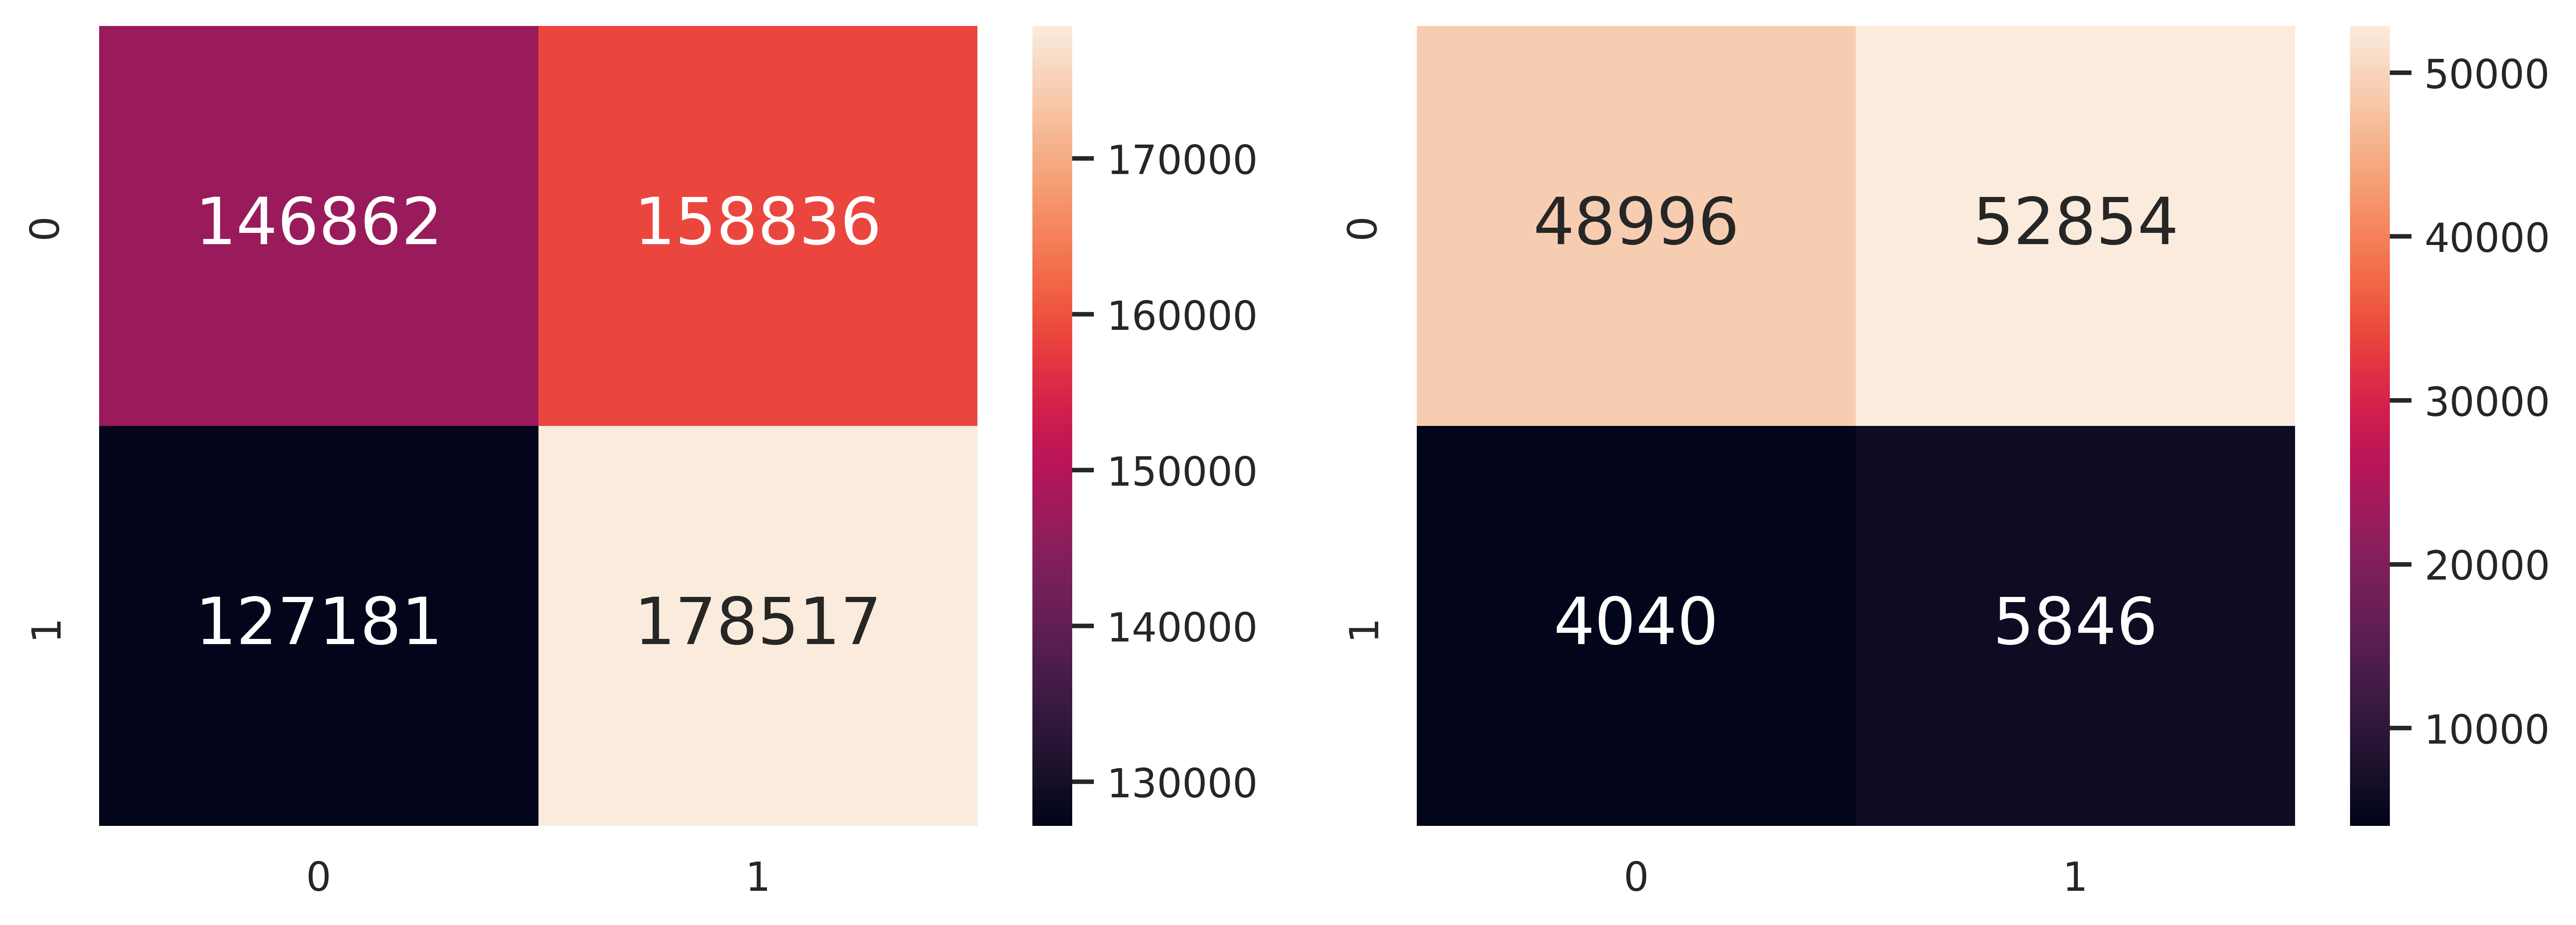

49.08

In [ ]:
# Select only 'Gender'
Gender_train_smote = pd.DataFrame(X_train_smote["Gender"])
Gender_test = pd.DataFrame(X_test["Gender"])

# Train
randomforest_gender = RandomForestClassifier(random_state=0)
randomforest_gender.fit(Gender_train_smote, Y_train_smote)

# Evaluate
confusionMatrix(Gender_train_smote, Y_train_smote, Gender_test, Y_test, randomforest_gender)

Classification Accuracy in train data 	: 0.5489306439688844
Train Data - True Positive Rate 	: 0.7588404242095139
Train Data - False Positive Rate 	: 0.6609791362717453
Train Data - Precision 	: 0.5344625791409008
Train Data - Recall 	: 0.7588404242095139
Train Data - F1 Score 	: 0.6271876106816775

Classification Accuracy in test data 	: 0.3751700436743753
Test Data - True Positive Rate 	: 0.7568278373457414
Test Data - False Positive Rate 	: 0.6618753068237604
Test Data - Precision 	: 0.09990119368707774
Test Data - Recall 	: 0.7568278373457414
Test Data - F1 Score 	: 0.1765038924274593


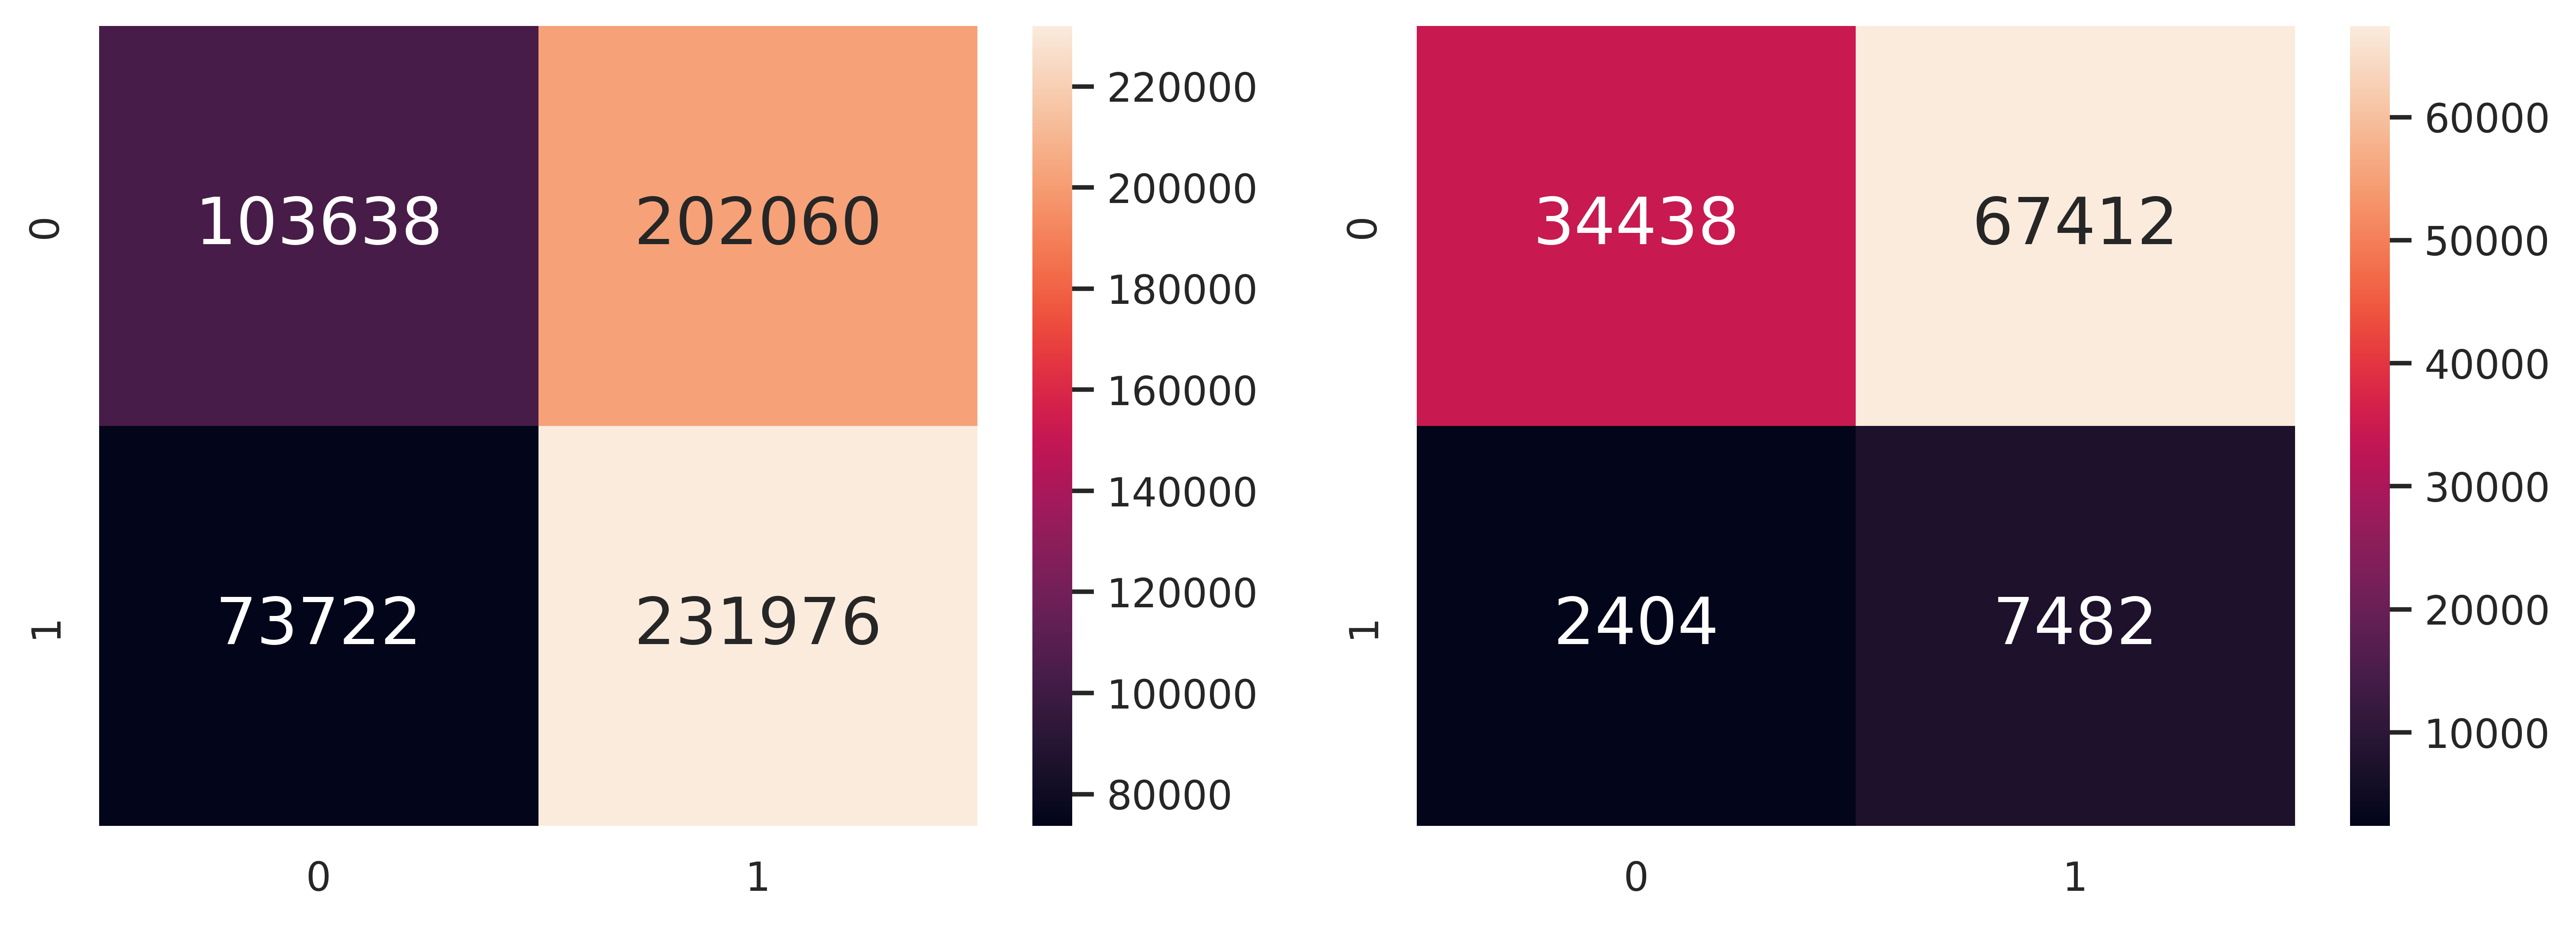

37.52

In [ ]:
# Select only 'Income_Category'
Income_train_smote = pd.DataFrame(X_train_smote["Income_Category"])
Income_test = pd.DataFrame(X_test["Income_Category"])

# Train
randomforest_income = RandomForestClassifier(random_state=0)
randomforest_income.fit(Income_train_smote, Y_train_smote)

# Evaluate
confusionMatrix(Income_train_smote, Y_train_smote, Income_test, Y_test, randomforest_income)

Based on the updated understanding that the dataset has been balanced using SMOTE, the most effective individual predictor of fraud is Income_Category. This is because it achieves the highest F1 Score (0.177) among the compared features, which balances both precision and recall—two crucial metrics in fraud detection. While Gender performs reasonably well with an F1 Score of 0.170 and better test accuracy (0.491), and Customer_Age has the highest accuracy (0.587), neither matches the F1 performance of Income_Category, making it the most effective predictor overall in a balanced data setting.

**7. Comparing Income_Category vs Attrition_Flag on Actual Test Data**

Classification Accuracy in train data 	: 0.5487954793055051
Train Data - True Positive Rate 	: 0.758794056160256
Train Data - False Positive Rate 	: 0.6612030975492458
Train Data - Precision 	: 0.534363082473817
Train Data - Recall 	: 0.758794056160256
Train Data - F1 Score 	: 0.6271032633217238

Classification Accuracy in test data 	: 0.37573872966262367
Test Data - True Positive Rate 	: 0.757959479015919
Test Data - False Positive Rate 	: 0.6610060432155124
Test Data - Precision 	: 0.09929027595113686
Test Data - Recall 	: 0.757959479015919
Test Data - F1 Score 	: 0.17558011628516054


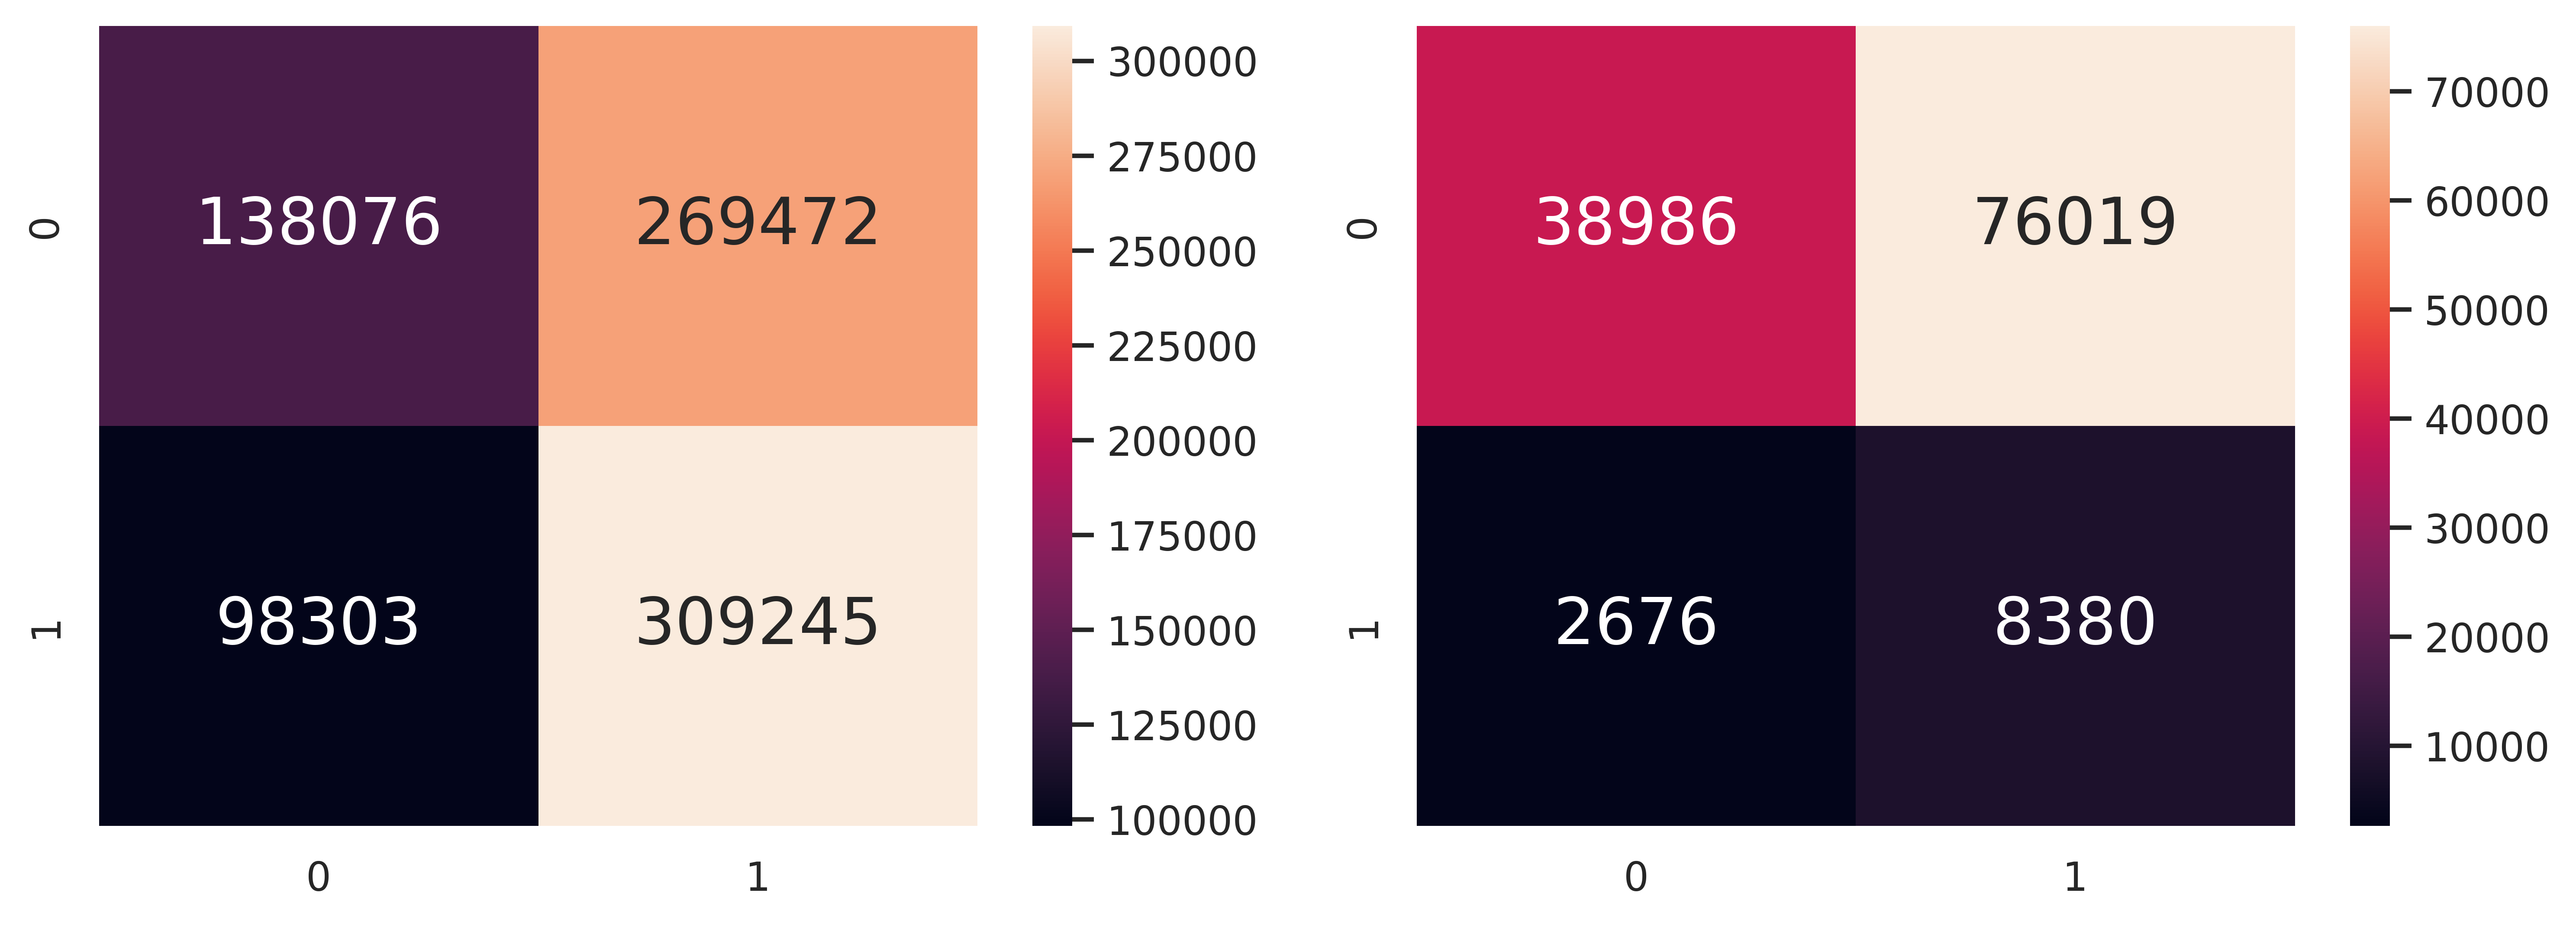

37.57

In [ ]:
# Extracting Income_Category and Attrition_Flag from both train and test data
x_actual_train = pd.DataFrame(Transformed_train_data["Income_Category"])
x_actual_test = pd.DataFrame(Transformed_test_data["Income_Category"])
y_actual_train = pd.DataFrame(Transformed_train_data["Attrition_Flag"])
y_actual_test = pd.DataFrame(Transformed_test_data["Attrition_Flag"])

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
x_actual_train_smote, y_actual_train_smote = smote.fit_resample(x_actual_train, y_actual_train.values.ravel())

# Random Forest Classification on Gender vs Attrition_Flag
randomforest = RandomForestClassifier(random_state=0)
randomforest.fit(x_actual_train_smote, y_actual_train_smote)

# Evaluate
confusionMatrix(x_actual_train_smote, y_actual_train_smote, x_actual_test, y_actual_test.values.ravel(), randomforest)

When tested on the actual test set, Income_Category remained the most effective individual predictor for fraud detection. It achieved a True Positive Rate of 75.8% and an F1 Score of 0.176, nearly identical to its training performance (TPR: 75.7%, F1 Score: 0.177). This strong consistency indicates that the model’s ability to detect fraudulent cases using this feature generalizes well to unseen data.

Although the overall accuracy is low (37.6%), this is expected in fraud detection, where maximizing the identification of actual fraud cases (recall) is more important than minimizing false positives. The stable F1 Score across both training and test sets reinforces Income_Category as the most reliable single predictor for identifying fraud.

**8. Conclusion**

Through the entire course the project, there are clear conclusions that we were able to draw from analyzing the datasets provided.

1. It is clear to use that out of all the different Prediction models we've used, we have found that Random Forest Classification method has the highest accuracy for predicting fraud in our data set.

2. We have also found that 3 predictors played an impactful part in the predictions, which are Gender, Income_Category and Customer_Age. With Income_Category being the best predictor out of the 3.